# Proximal Policy Optimization (PPO)

Proximal Policy Optimization (PPO) is a policy-gradient reinforcement learning algorithm that trains an *actor* (policy) and a *critic* (value function) together. It improves the policy using batches of collected trajectories while keeping updates “proximal” (not too large), which makes training more stable and sample-efficient than vanilla policy gradients.

Key ideas:
- **Actor–Critic**:  
  - Actor: outputs a probability distribution over actions.  
  - Critic: estimates the value function \(V(s)\) to reduce variance of gradient estimates.
- **Clipped objective**

  PPO uses a clipped surrogate objective to keep the new policy close to the old one:

  `L_clip(θ) = E_t[ min( r_t(θ) * A_t, clip(r_t(θ), 1 - ε, 1 + ε) * A_t ) ]`

  where

  `r_t(θ) = π_θ(a_t | s_t) / π_{θ_old}(a_t | s_t)`

  and `A_t` is the advantage estimate.

- **On-policy with mini-batches**:  
  Uses trajectories from the current policy, but performs multiple epochs of SGD on the same batch (with clipping to stay stable).
- **Generalized Advantage Estimation (GAE)**:  
  Often combined with PPO to compute smoother, lower-variance advantages from value predictions.

In practice, PPO is popular because it is relatively easy to implement, works well with neural networks, and tends to be robust across a variety of environments and hyperparameters.


Version log:
* 0.9 restart
    * using DQN lessons learned as template
* 0.10 fixed agent, oppo labels
* 0.11 horizontal, color swaps
* 0.12 learning not improved - dev paused or stopped
* 0.20 restarted with corrected  LA and ENV
* 0.30 restart redesign;
* 0.31 changed ENV weights
* 0.32 zero-sum approach
* 0.33 more center forced env
* 0.34 mentoring; warm start, offline RL
* 0.35 noseed
* 0.36 only odd teachers/mentor
* 0.37 guards to  0.0
* 0.40 to1-channel transfer learning

## Links, learning from
[https://github.com/marcpaulo15/RL-connect4/tree/main](https://github.com/marcpaulo15/RL-connect4/tree/main)<br>
[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
[https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/](https://www.geeksforgeeks.org/machine-learning/understanding-prioritized-experience-replay/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>


## Import dependecies and recheck installation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
import pprint;
import pandas as pd
import os
from IPython.display import display, clear_output, HTML

import warnings

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 4090
cuda


### Fixed Random seeds

In [2]:
SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

## Custom imports

In [3]:
from C4.connect4_env import Connect4Env
from C4.fast_connect4_lookahead import Connect4Lookahead
from PPO.ppo_training_phases_config import TRAINING_PHASES
from PPO.actor_critic import ActorCritic
from PPO.phase_tracker import PhaseTracker, display_phases_table
from C4.CNet192 import CNet192, save_cnet192, load_cnet192
from C4.connect4_env import Connect4Env
from PPO.ppo_buffer import PPOBuffer, PPOHyperParams
from PPO.ppo_update import PPOUpdateCfg, ppo_update
from C4.opening_tracker import OpeningTracker, init_opening_kpis, record_first_move, summarize_opening_kpis
from DQN.dqn_utilities import update_benchmark_winrates, track_result, h2h_append
from C4.connect4_board_display import display_final_boards_PPO
from PPO.ppo_live_plot import plot_live_training_ppo
from C4.utilities import *
from PPO.ppo_opponent_sampler import OpponentSampler
from PPO.ppo_agent_eval import *
from PPO.ppo_loop_helpers import *
from C4.eval_oppo_dict import *
from PPO.ppo_hall_of_fame import PPOHallOfFame
from PPO.LookaheadMentor import LookaheadMentor

print("Imports succesfull!")

Lookahead = Connect4Lookahead()

Imports succesfull!


## Constants

In [4]:
plot_interval = 10 

In [5]:
LOG_DIR ="Logs/PPO/"
MODEL_DIR ="Models/PPO/"
PLOTS = "Plots/PPO/"
TEMP_DIR ="Models/PPO/TEMP/"           
reset_dir(TEMP_DIR)   

In [6]:
# hard defaults
STEPS_PER_UPDATE    = 8192           # agent decisions per PPO update
LEARNING_RATE       = 3e-4           # phase derived
TEMPERATURE         = 1.0            # 0.0 = greedy sampling, phase derived
ATTR_LOSS_TO_LAST   = True           # attribute opponent's terminal win to our last move
CLEAR_BUFFER_ON_PHASE_CHANGE = True  # avoid leaking rollouts across phases
BENCHMARK_EVERY     = 20
H2H_EVERY           = BENCHMARK_EVERY 
AUG_MULT            = 8
REWARD_SCALE        = 10 / Connect4Env.WIN_REWARD

# Training phases

In [7]:
PHASES = PhaseTracker(TRAINING_PHASES)
L, lastPhase=display_phases_table(TRAINING_PHASES)
print(L, lastPhase)

3100 Finale


# Training session name - settings


In [8]:
number_episodes = L # all
begin_start_time = time.time()
model_path = "PPO_Models/MIX_7a.pt" 
#model_path = "SupervisedModels/EXPERT_3.pt" #še 5
model_name = model_path.split("/")[-1].split(".")[0]
run_name =  "L13"[:10]
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
tag = f"{run_name}-{lastPhase}-{model_name}"
TRAINING_SESSION = f"PPQ-{number_episodes}-{tag} - at-{time_str}"
print("Start training session", TRAINING_SESSION)

Start training session PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-12-24


## Hall of Fame / policy ensemble

In [9]:
HOF_METASCORES = {
    "PPO_Models/MIX_11.pt": 0.747250,
    "PPO_Models/MIX_7a.pt": 0.501000,
    "PPO_Models/MIX_7b.pt": 0.453250,
    "PPO_Models/MIX_8.pt": 0.439000,
    "PPO_Models/MIX_10.pt": 0.359500,
}


In [10]:
hof = PPOHallOfFame(device=DEVICE)

for path, score in HOF_METASCORES.items():
    name = path.split("/")[-1].split(".")[0]
    hof.add_member(name=name, ckpt_path=path, metascore=score)

print("HOF members:", hof.list_members())
POP_ENSEMBLE_NAMES = hof.list_members()  # use all 
pop_ensemble_policy = hof.build_ensemble(POP_ENSEMBLE_NAMES, use_metascore_weights=True)

for p in pop_ensemble_policy.parameters(): p.requires_grad = False
pop_ensemble_policy.eval()
print(f"using {len(POP_ENSEMBLE_NAMES)} checkpoints in ensemble")

HOF members: ['MIX_7b', 'MIX_7a', 'MIX_8', 'MIX_10', 'MIX_6b', 'MIX_6a']
using 6 checkpoints in ensemble


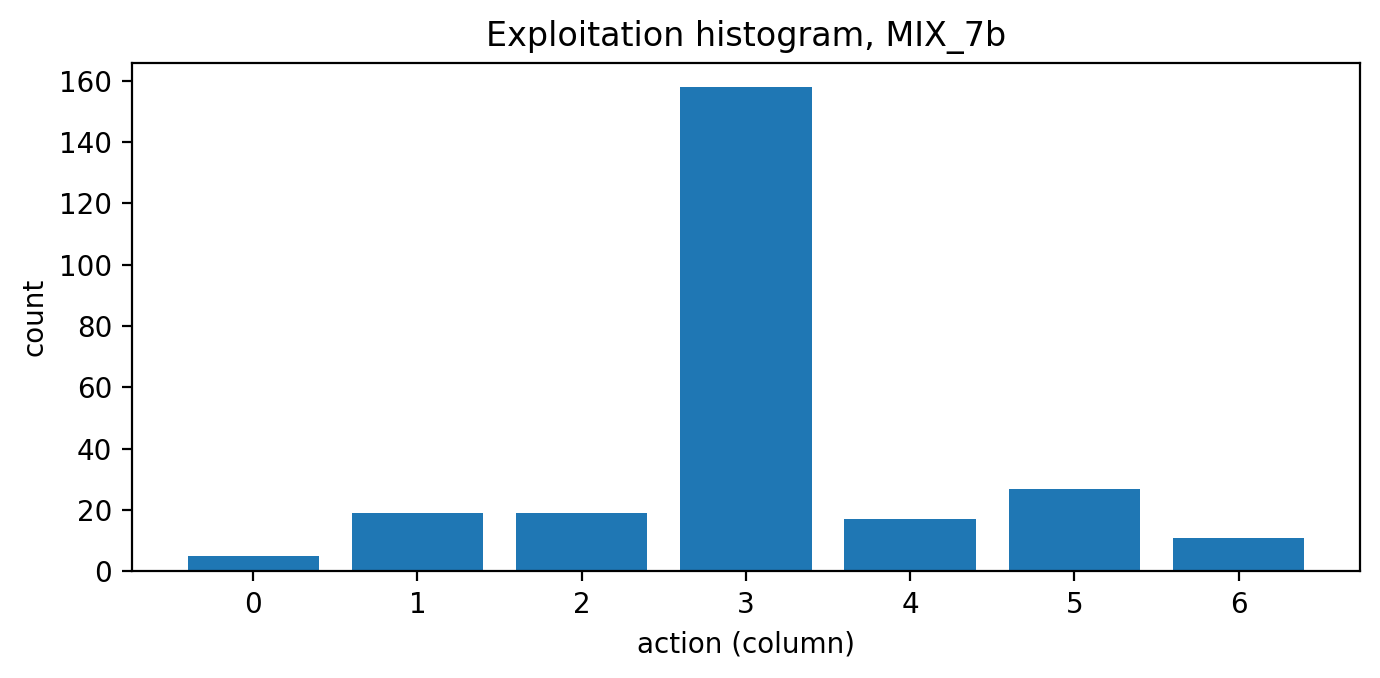

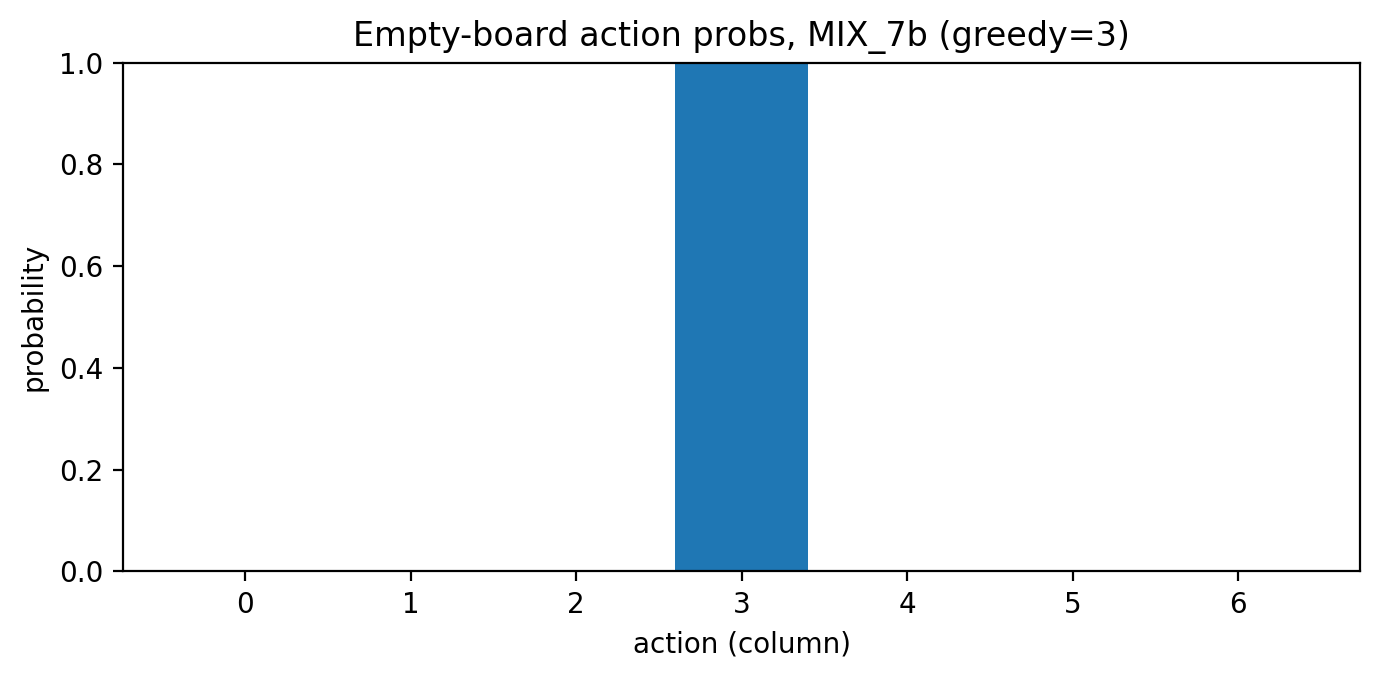

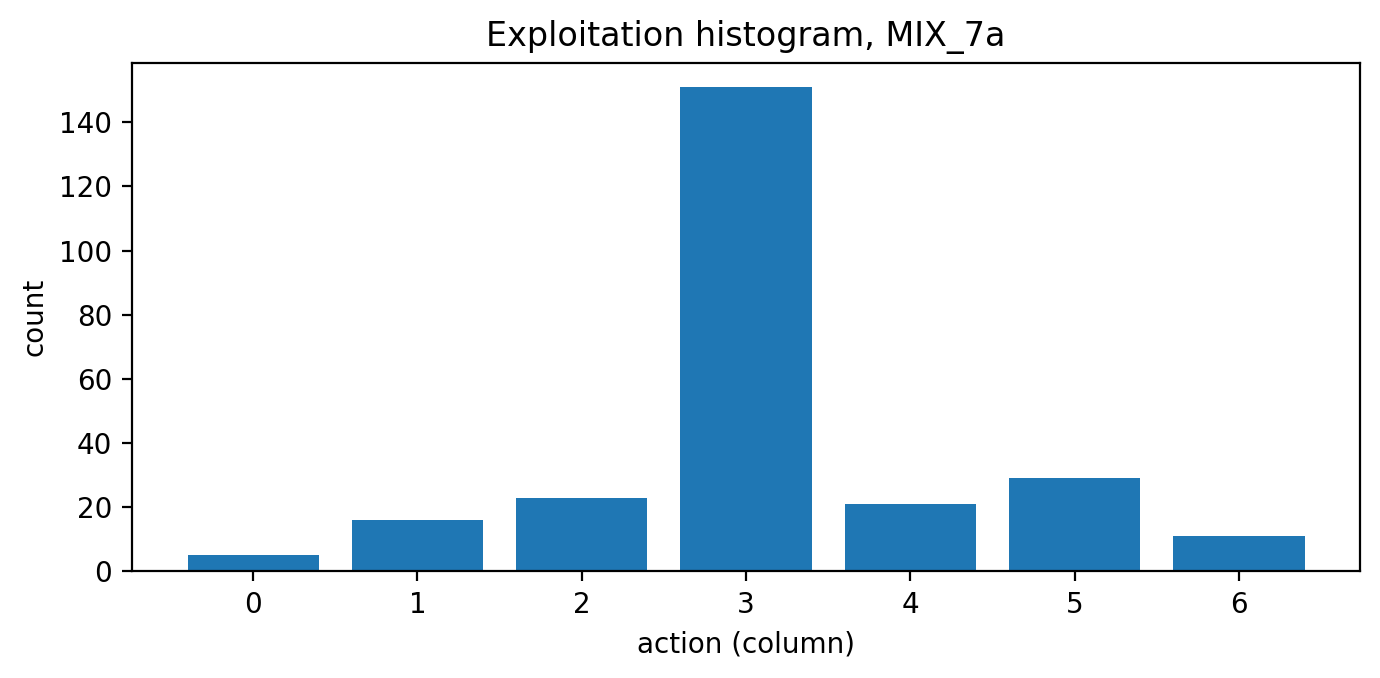

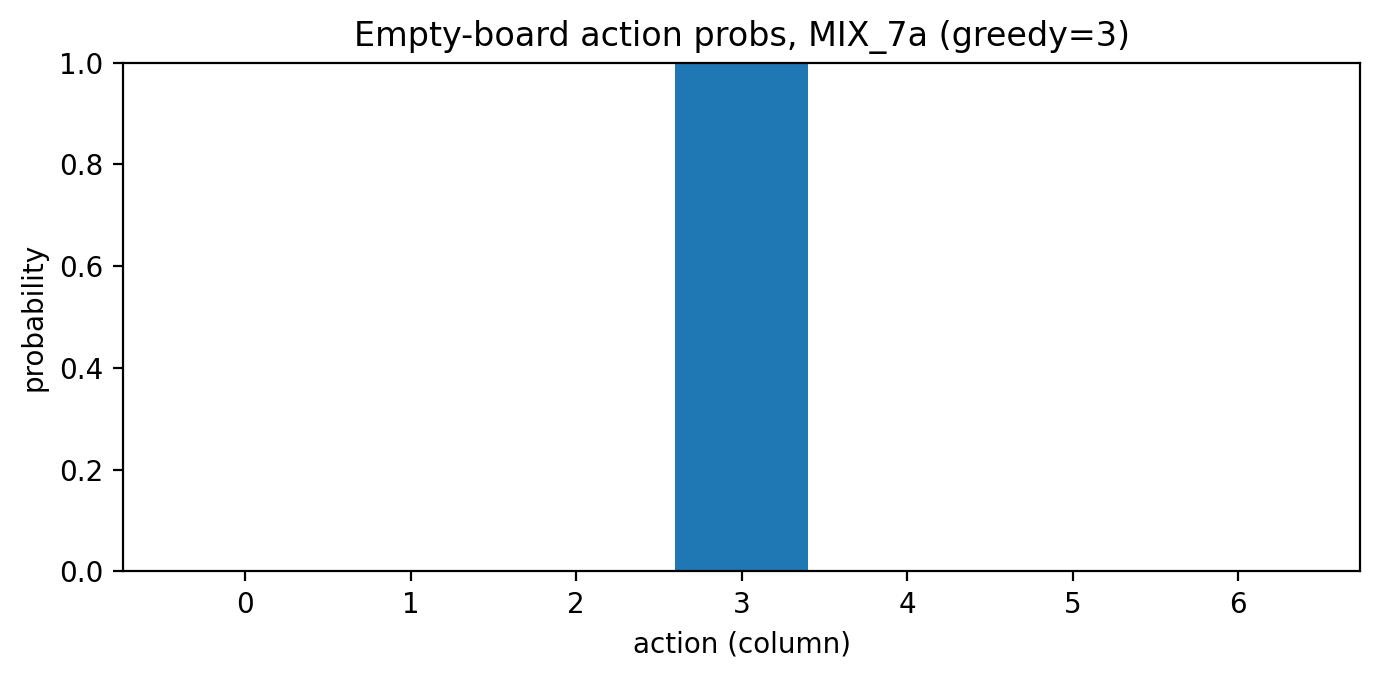

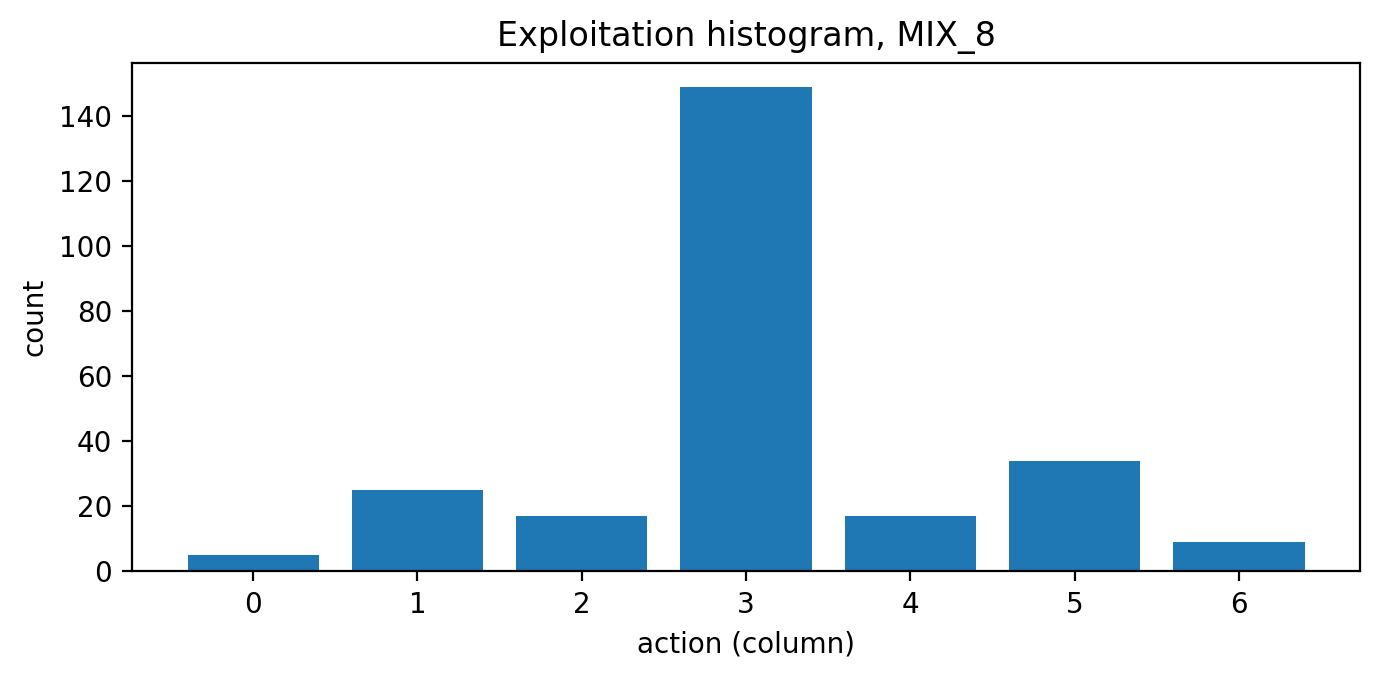

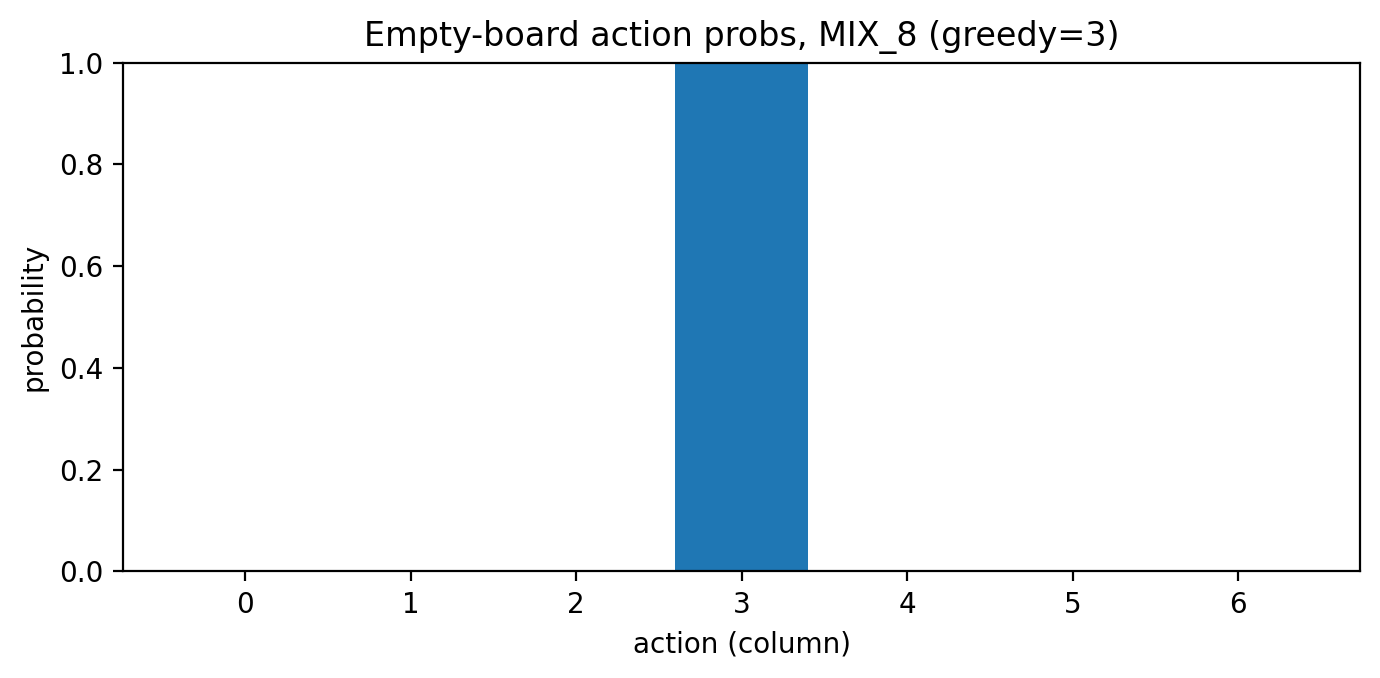

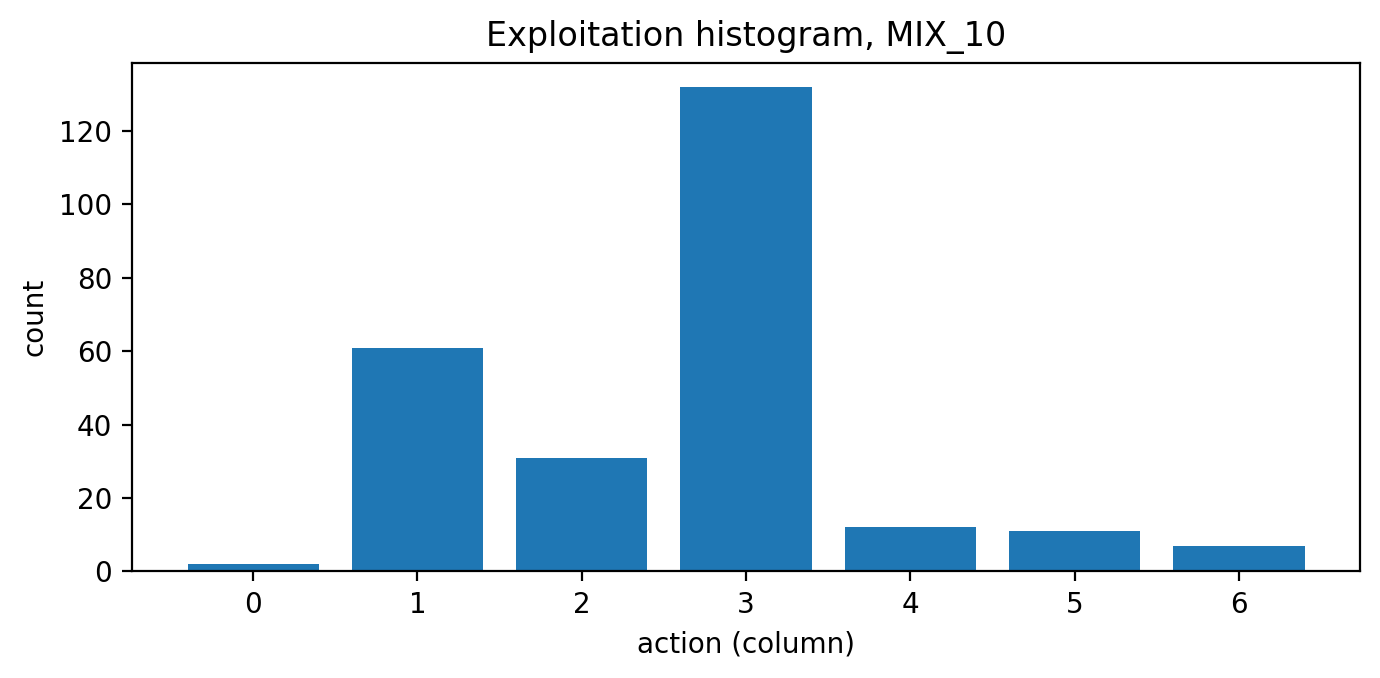

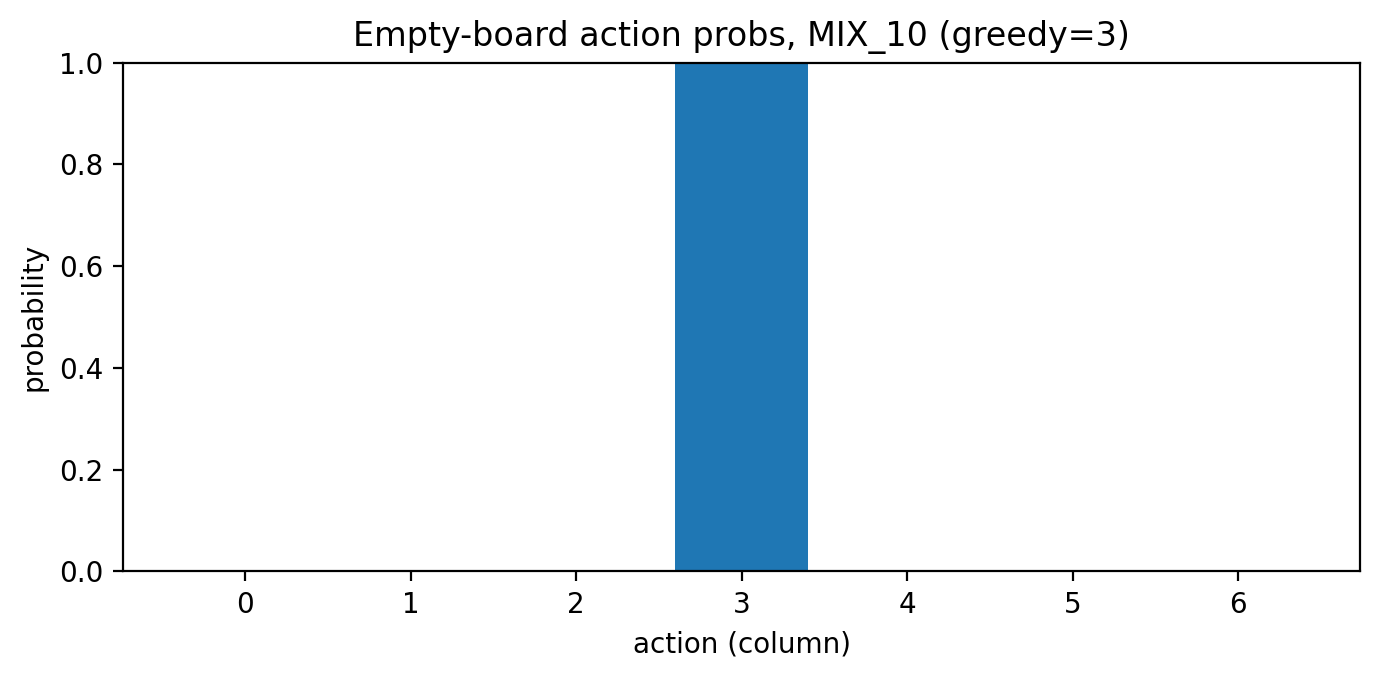

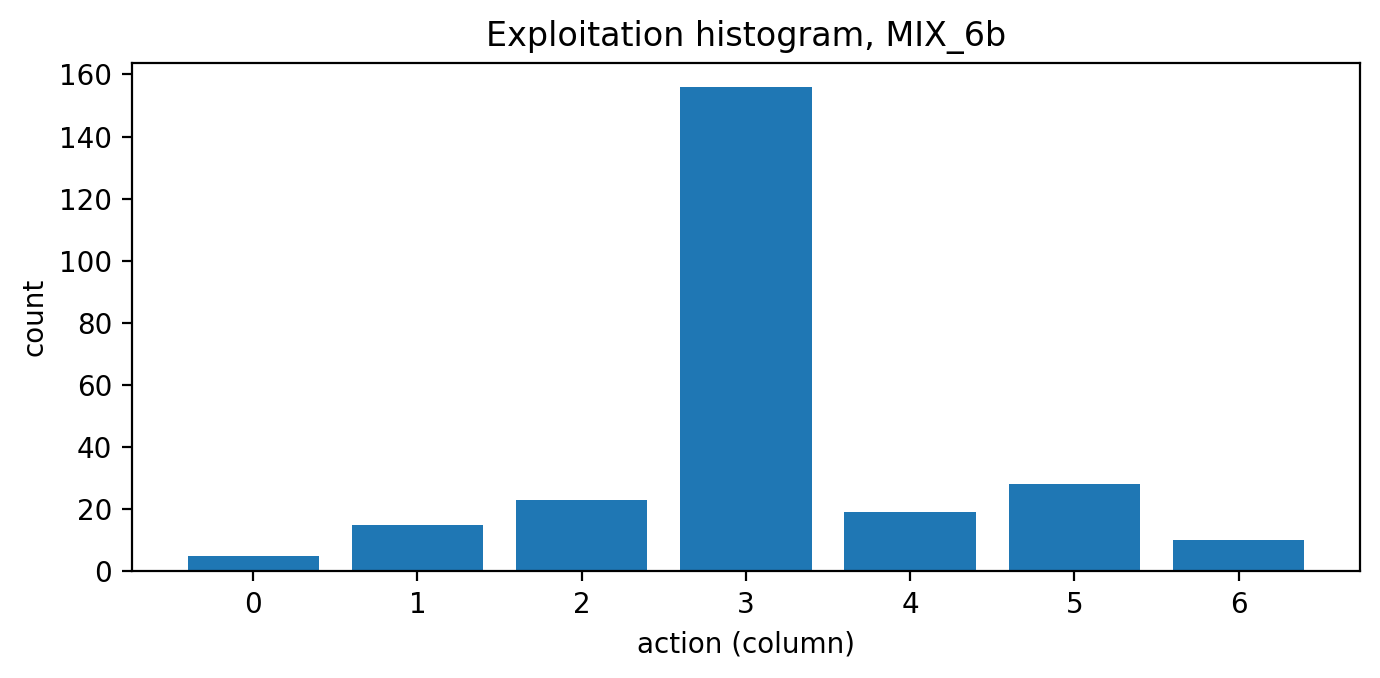

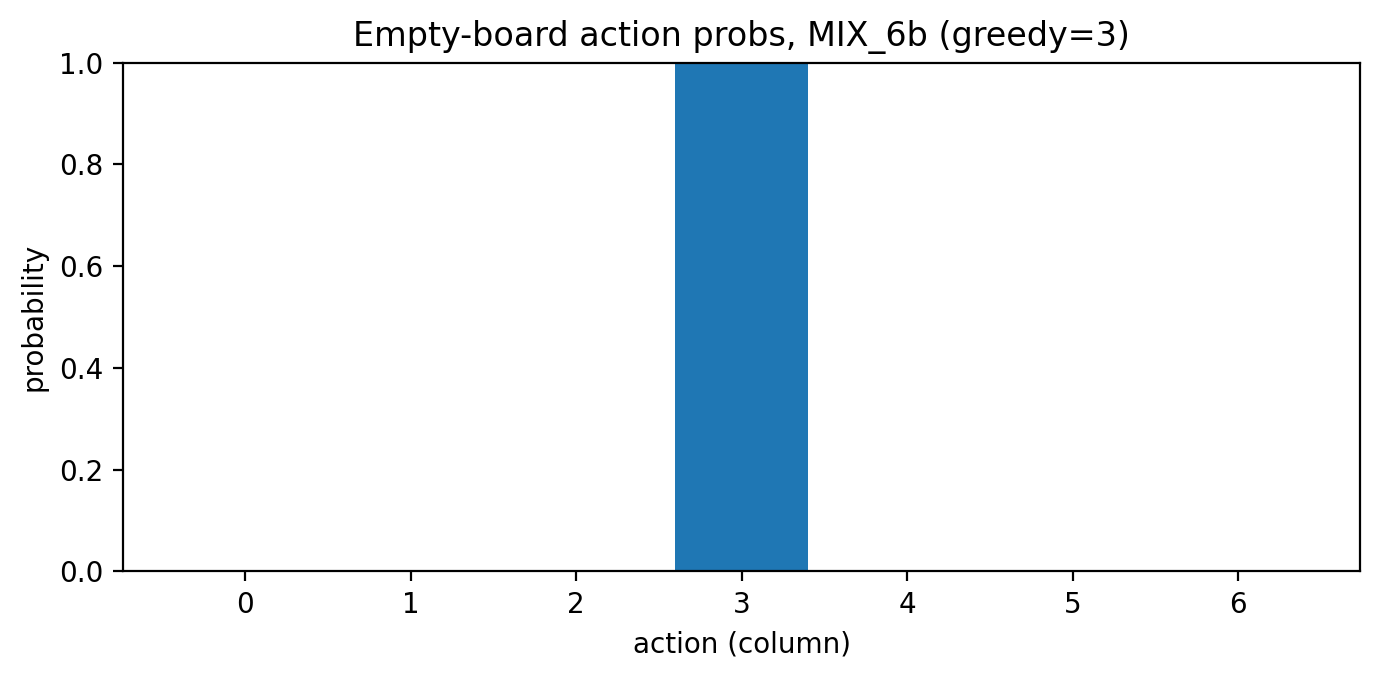

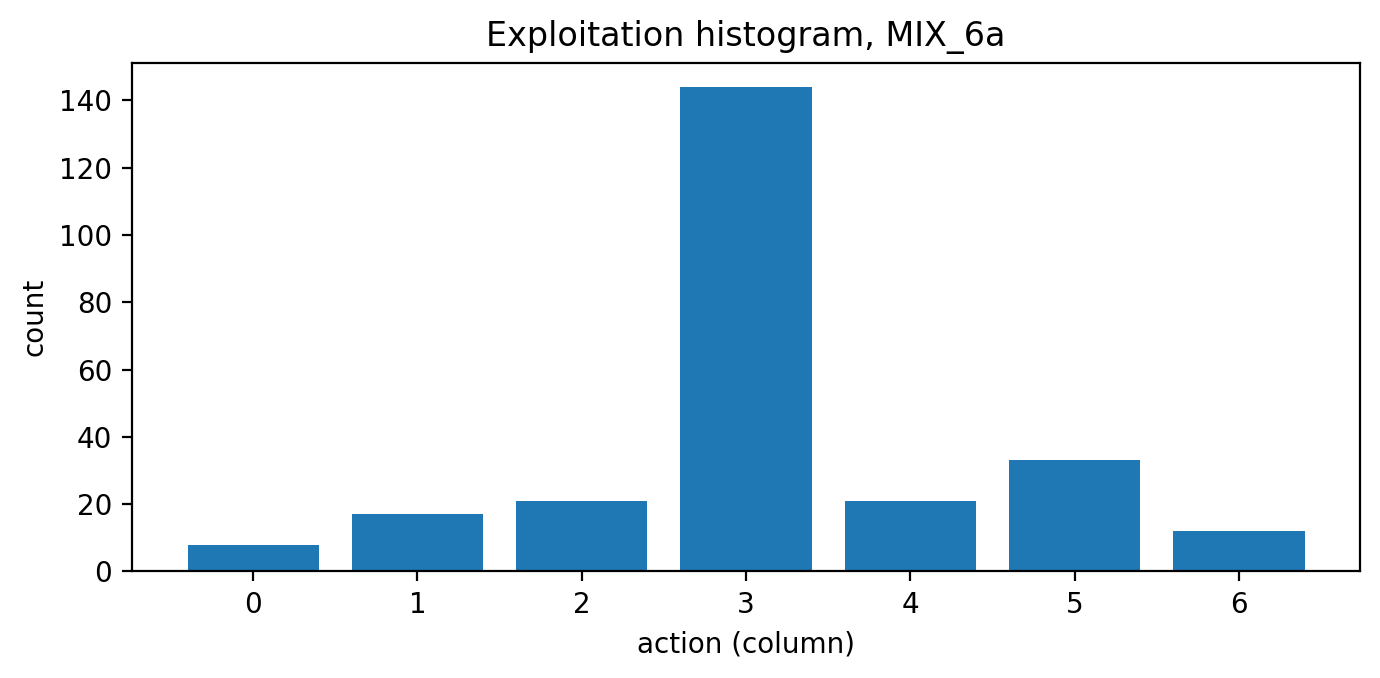

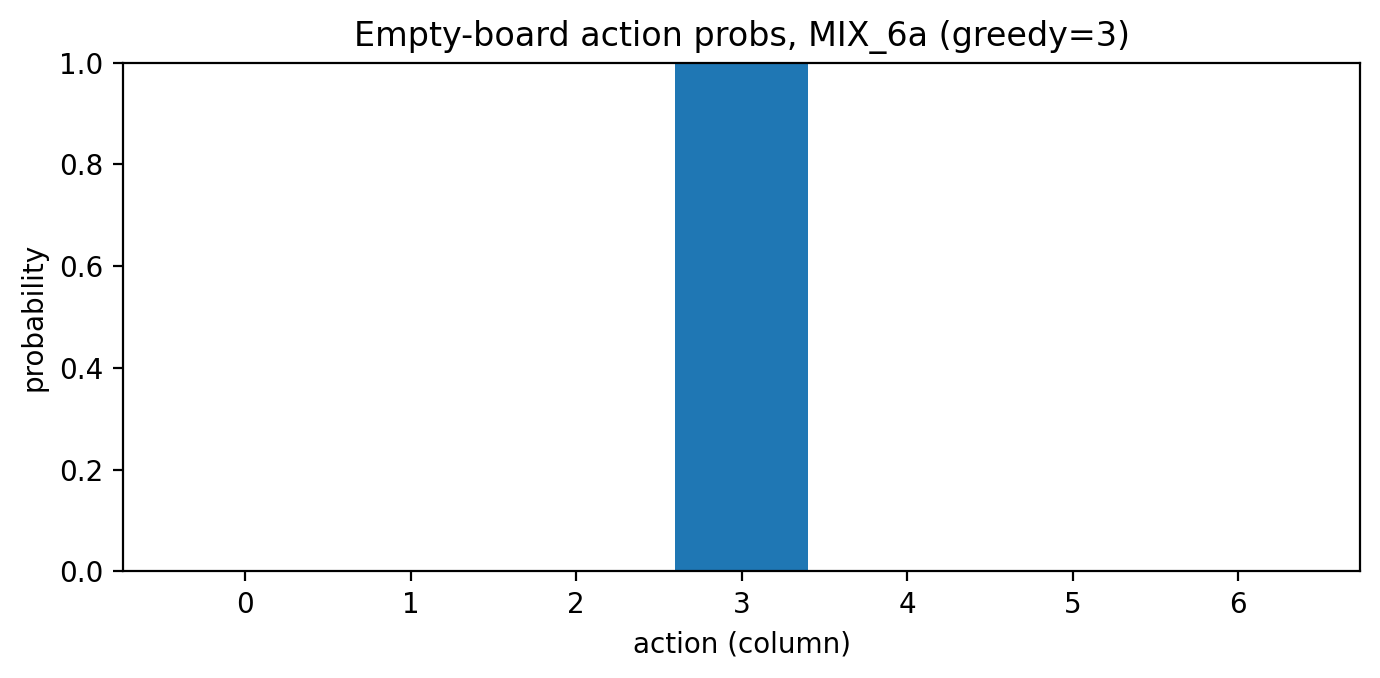

In [11]:
for name in hof.list_members():  # or: for name in hof.members.keys()
    policy = hof.ensure_loaded(name)  # <-- important if policies are lazy-loaded

    counts = exploitation_histogram(
        policy,
        device=DEVICE,
        n_states=256,
        rng_seed=666,
    )
    fig1 = plot_exploitation_histogram(counts, model_name=name)
    display(fig1)
    plt.close(fig1)

    fig2 = plot_empty_board_action_distribution(
        policy,
        device=DEVICE,
        model_name=name,
    )
    display(fig2)
    plt.close(fig2)

# PPO

✅ Loaded: PPO_Models/MIX_7b.pt
cfg.use_mid_3x3 = True
Params trainable/total: 297032/779912  (conv block frozen)


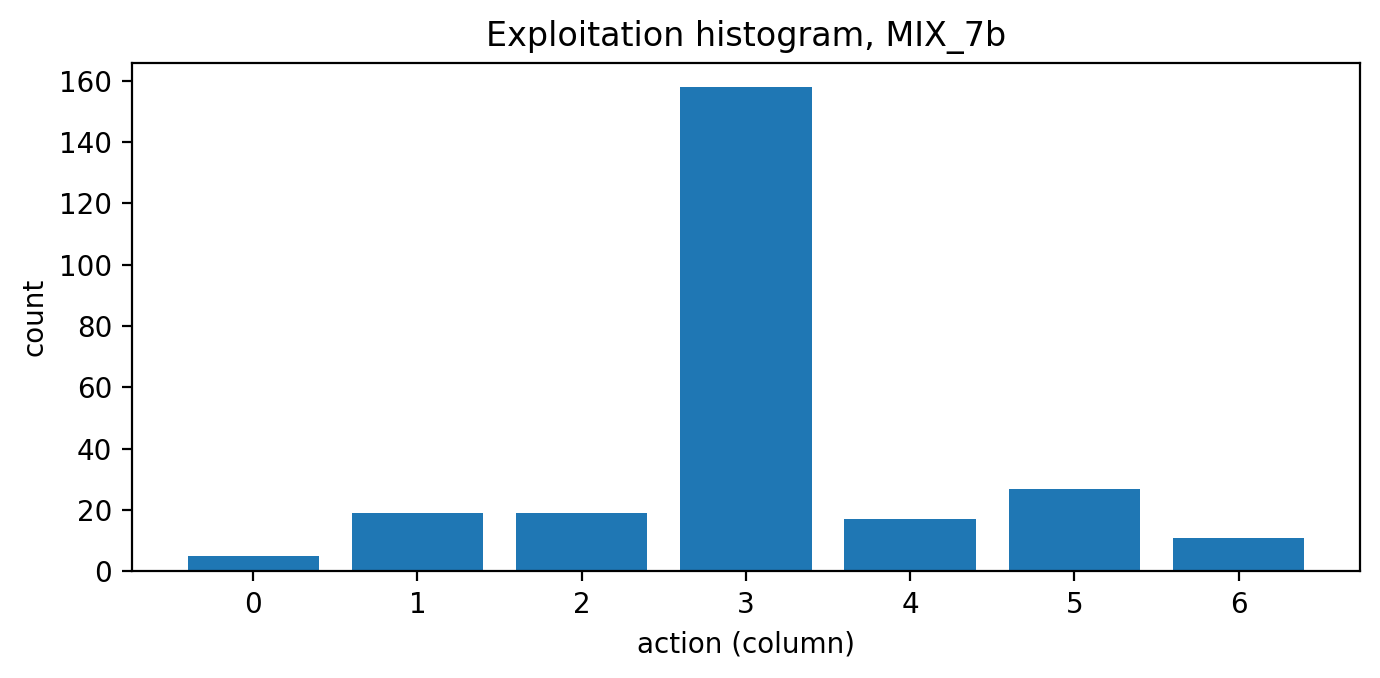

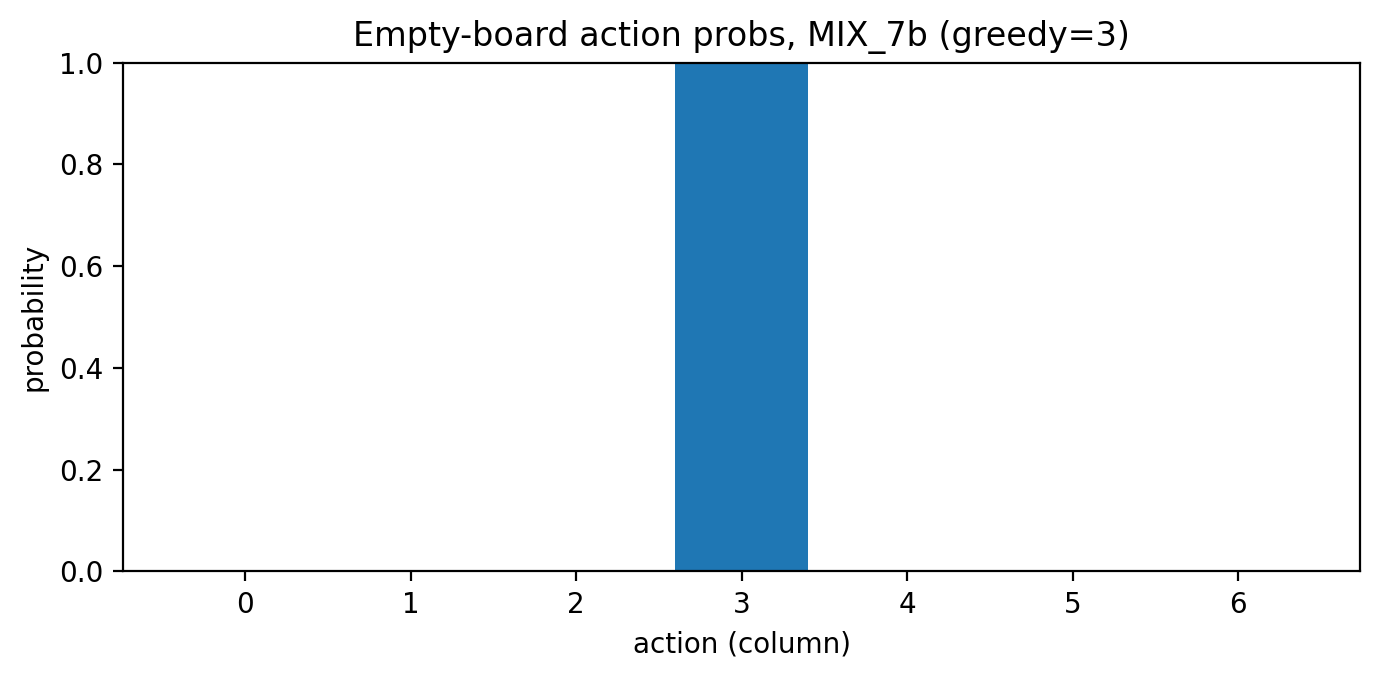

In [12]:
cnet, ckpt = load_cnet192(path=model_path, device=DEVICE, strict=True)
cfg  = ckpt.get("cfg", {}) if isinstance(ckpt, dict) else {}
meta = ckpt.get("meta", None) if isinstance(ckpt, dict) else None
use_mid = bool(cfg.get("use_mid_3x3", True))

policy = ActorCritic(use_mid_3x3=use_mid).to(DEVICE)
policy.net.load_state_dict(cnet.state_dict(), strict=True)

# --- freeze conv block (transfer-style) ---
policy.freeze_conv_block(True)

policy.eval()
print(f"✅ Loaded: {model_path}")
print(f"cfg.use_mid_3x3 = {use_mid}")
if meta:
    print(f"Meta — episode:{meta.get('episode', None)}  ts:{meta.get('timestamp','')}")

total = sum(p.numel() for p in policy.parameters())
trainable = sum(p.numel() for p in policy.parameters() if p.requires_grad)
print(f"Params trainable/total: {trainable}/{total}  (conv block frozen)")

# --- quick diagnostics ---
counts = exploitation_histogram(policy, device=DEVICE, n_states=256, rng_seed=666)
fig1 = plot_exploitation_histogram(counts, model_name=model_name)
fig2 = plot_empty_board_action_distribution(policy, device=DEVICE, model_name=model_name)

display(fig1)
display(fig2)


In [13]:
summary(policy)

Layer (type:depth-idx)                   Param #
ActorCritic                              --
├─CNet192: 1-1                           --
│    └─Conv2d: 2-1                       (3,264)
│    └─Conv2d: 2-2                       (331,968)
│    └─Conv2d: 2-3                       (147,648)
│    └─Linear: 2-4                       221,376
│    └─Linear: 2-5                       37,056
│    └─Linear: 2-6                       1,351
│    └─Linear: 2-7                       37,056
│    └─Linear: 2-8                       193
Total params: 779,912
Trainable params: 297,032
Non-trainable params: 482,880

In [14]:
# ==== H2H inline metric config ====
H2H_ENABLED      = True
H2H_GAMES        = 200           # e.g., 150–250 ~ quick
H2H_SEED         = SEED

H2H_BASELINE_PATH = f"{TEMP_DIR}H2H_baseline.pt"
H2H_KEEP_TEMPS    = 200          # keep last N temp ckpts
h2h_history       = {"episode": [], "score": [], "lo": [], "hi": [], "n": []}
ensemble_h2h_history       = {"episode": [], "score": [], "lo": [], "hi": [], "n": []}
_h2h_temp_paths   = []
hth_best_score    = -1.0

baseline_model = policy.net if hasattr(policy, "net") else policy
assert isinstance(baseline_model, torch.nn.Module), f"baseline_model must be nn.Module, got {type(baseline_model)}"

baseline_model.eval()
save_cnet192(
    model=baseline_model,
    path=H2H_BASELINE_PATH,
    meta={"tag": "H2H_baseline", "episode": 0, "seed": int(H2H_SEED)},
)

print(f"✅ H2H baseline saved to: {H2H_BASELINE_PATH}")

✅ H2H baseline saved to: Models/PPO/TEMP/H2H_baseline.pt


In [15]:
# --- Env / Policy / Optimizer / Buffer ---
env = Connect4Env()

# Freeze conv block (train heads only)
policy.freeze_conv_block(True)
#policy.freeze_conv_block(False)

# Optimizer: ONLY trainable params (since we froze conv)
trainable_params = [p for p in policy.parameters() if p.requires_grad]
optim = torch.optim.AdamW(trainable_params, lr=LEARNING_RATE, eps=1e-4, weight_decay=5e-5)
hparams = PPOHyperParams(gamma=0.95, gae_lambda=0.95, normalize_adv=True)
buffer = PPOBuffer(capacity=STEPS_PER_UPDATE * AUG_MULT, action_dim=7, hparams=hparams, reward_scale=0.005, device=DEVICE)

cfg = PPOUpdateCfg(
    epochs=5,
    batch_size=32,
    clip_range=0.20,
    vf_clip_range=0.20,
    ent_coef=0.010,
    vf_coef=0.75,
    max_grad_norm=0.5,
    target_kl=0.03,
    temperature=1.0,
    distill_coef=0.0,       
    mentor_depth=1,
    mentor_prob=0.0,
    mentor_coef=0.0,
)

# Openings tracker (now a clean module)
openings = OpeningTracker(cols=7, log_every=plot_interval, ma_window=12)
opening_kpis = openings.kpis  

In [16]:
# --- Logging / histories ---
win_history = []  

ppo_metrics_history = {
    "episodes": [],
    "loss_pi": [],
    "loss_v": [],
    "entropy": [],
    "approx_kl": [],
    "clip_frac": [],
    "explained_variance": [],
}

update_idx = 0
steps_collected = 0
reward_history = []              # per-episode total reward
benchmark_history  = None
wins = losses = draws = 0
win_count  = 0
loss_count = 0
draw_count = 0
win_history= []

# --- opponent overlay / logging helpers ---
opponent_timeline: list[str] = []   # one short key per episode -> drives the overlay
sampled_opponent_key: str | None = None
phase_mix: dict[str, float] = {"R": 1.0}  # default shown in logs (no effect yet)


### Live plot

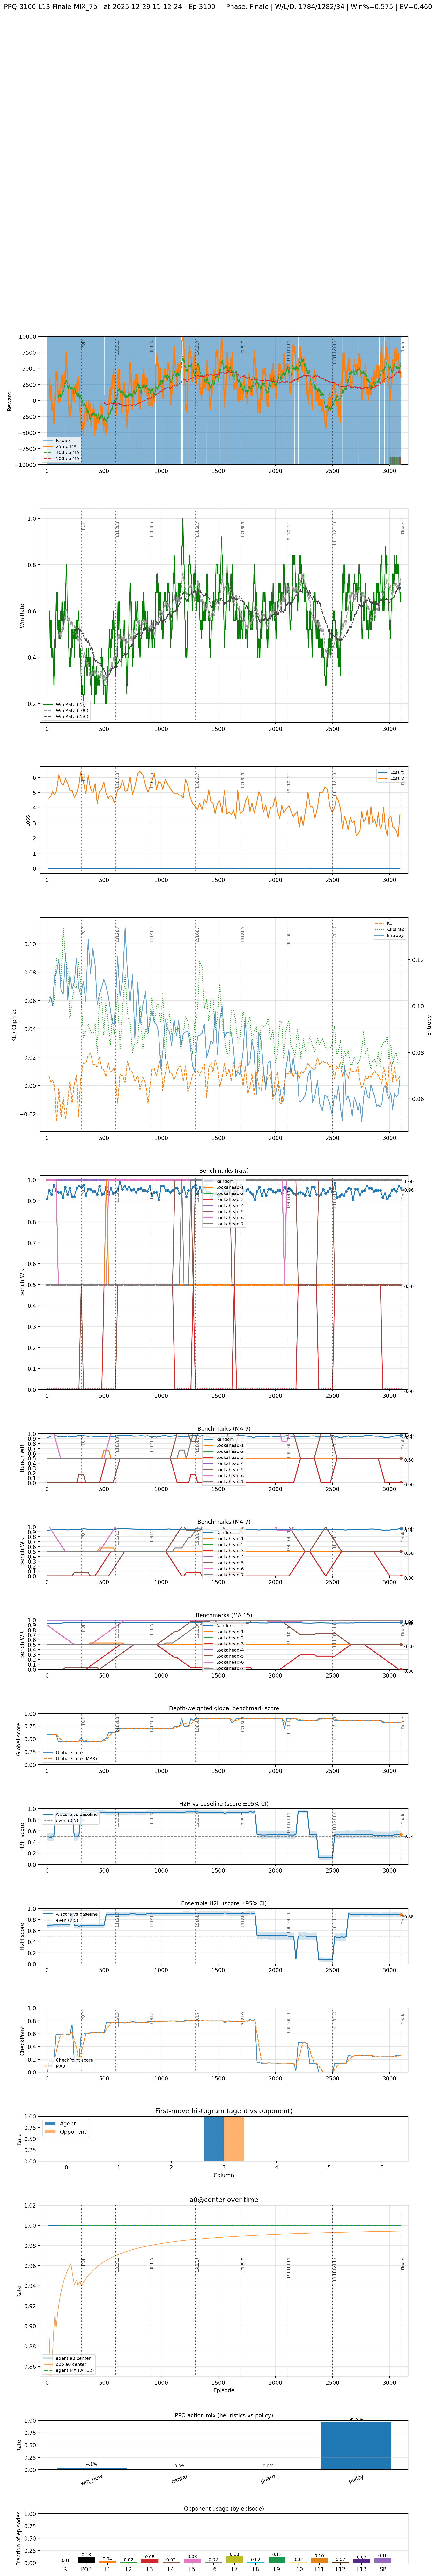

In [17]:
plots_handle = display(HTML("<b>Live training plot will appear here.</b>"), display_id=True)
fig = None 

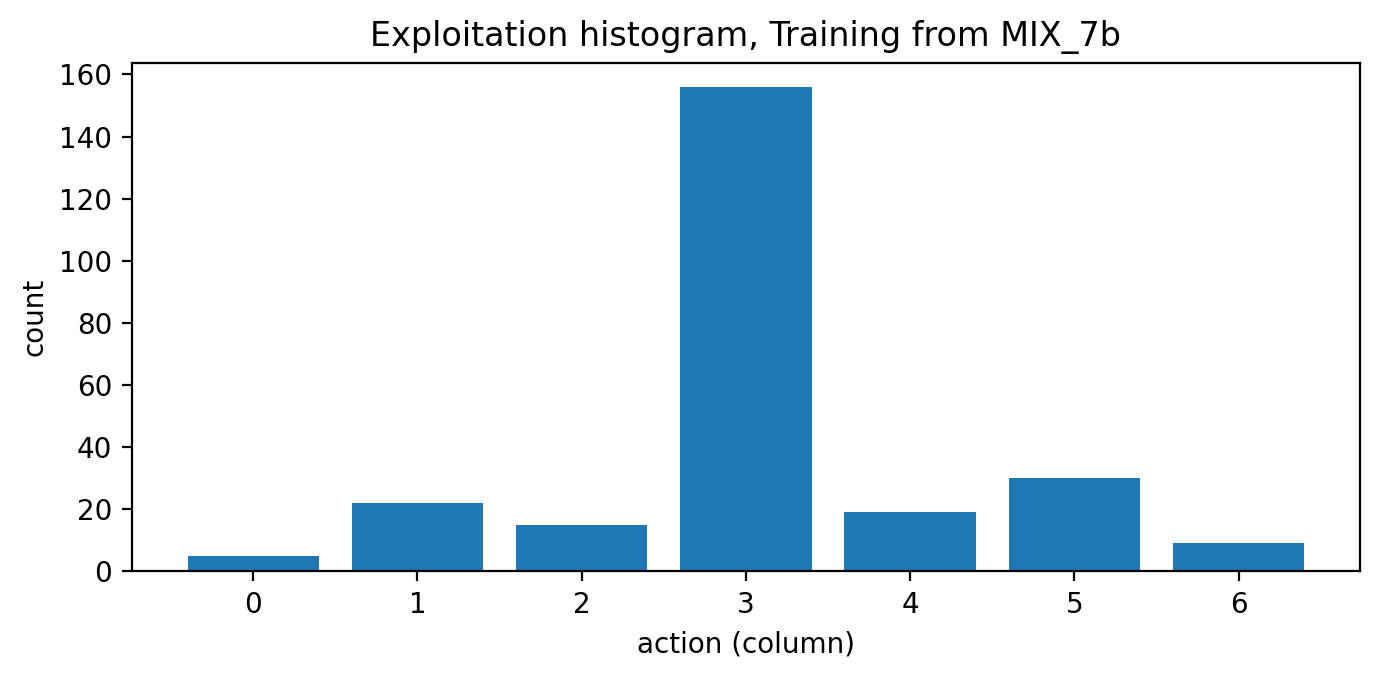

In [18]:
eh_handle    = display(HTML("<b>Exploitation histogram will appear here.</b>"), display_id=True)
EH = None

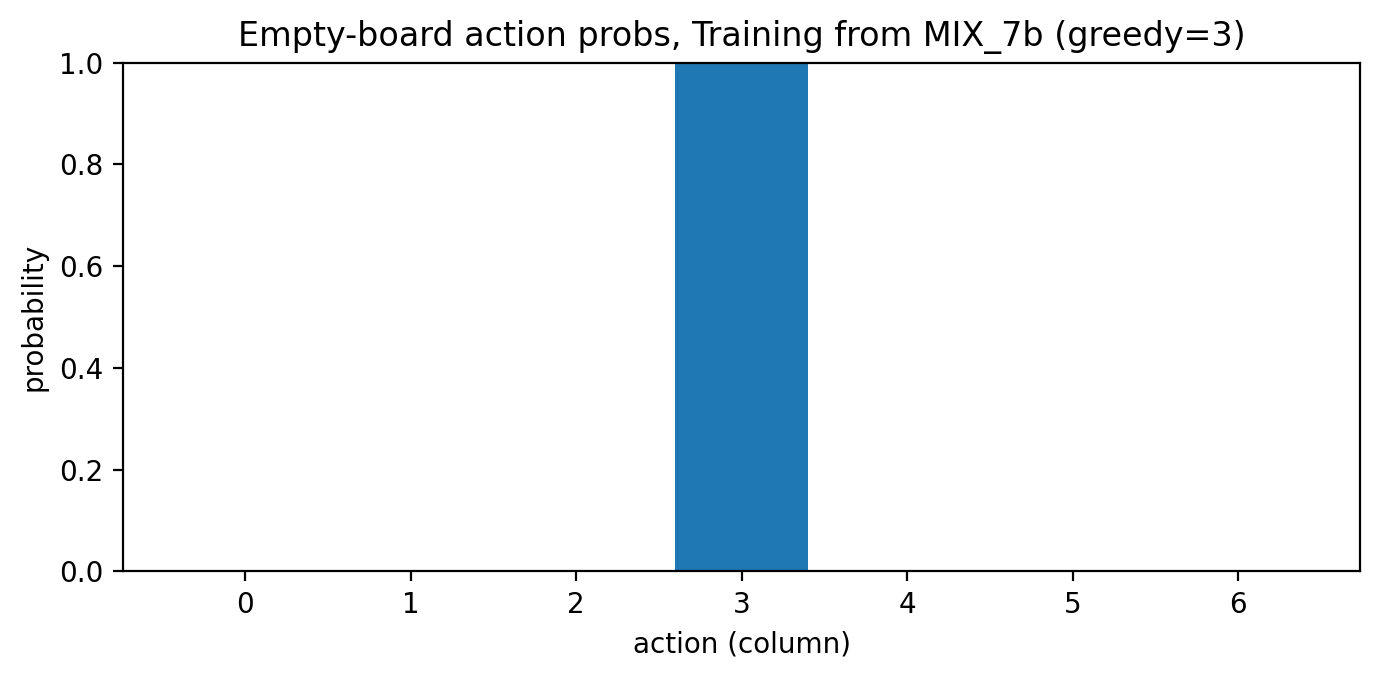

In [19]:
eba_handle   = display(HTML("<b>Empty-board action distribution will appear here.</b>"), display_id=True)
EBA = None

## Training Loop

In [20]:
# ============================
# PPO TRAINING LOOP  (Cell 22)
# ============================

# temp state
steps_collected = 0
update_idx = 0
current_phase_name = None
last_agent_reward_entries_ref = [None]  # 1-slot box mutated in helpers
current_mentor = None

# phase-aware temperature (mutated in-place)
temperature_ref = {"T": 1.0}
recompute_fn = make_recompute_lp_val(policy, temperature_ref)

# H2H: keep last known scores so benchmark/logging can always write something sensible
last_h2h_score = 0.0
last_pop_score = 0.0

# H2H baseline model (frozen) for head_to_head_models()
h2h_baseline_model = None
if H2H_ENABLED:
    h2h_baseline_model, _ = load_cnet192(H2H_BASELINE_PATH, device=DEVICE, strict=True)
    h2h_baseline_model.eval()
    for p in h2h_baseline_model.parameters():
        p.requires_grad_(False)

start_time = time.time()

with tqdm(total=number_episodes, desc="Episodes", leave=True, dynamic_ncols=True) as epbar:
    opponent_sampler = None

    for episode in range(1, number_episodes + 1):
        # --- defaults for this episode (for downstream logging/benchmark) ---
        score = last_h2h_score
        ensemble_score = last_pop_score

        # --- curriculum phase ---
        phase_info, changed = PHASES.start_episode(episode)
        current_phase_name = phase_info.name

        if changed:
            # ---- apply phase params ----
            p = params_for_phase(current_phase_name, cfg)

            # mentor
            if p["mentor_prob"] > 0.0 and p["mentor_coef"] > 0.0:
                current_mentor = LookaheadMentor(depth=p["mentor_depth"], device=DEVICE)
            else:
                current_mentor = None

            # optimizer LR
            for g in optim.param_groups:
                g["lr"] = p["lr"]

            # PPO update cfg
            cfg.clip_range    = p["clip"]
            cfg.ent_coef      = p["entropy"]
            cfg.epochs        = p["epochs"]
            cfg.target_kl     = p["target_kl"]
            cfg.vf_coef       = p["vf_coef"]
            cfg.vf_clip_range = p["vf_clip"]
            cfg.batch_size    = p["batch_size"]
            cfg.max_grad_norm = p["max_grad_norm"]
            cfg.temperature   = p["temperature"]
            temperature_ref["T"] = p["temperature"]

            cfg.mentor_depth = p["mentor_depth"]
            cfg.mentor_prob  = p["mentor_prob"]
            cfg.mentor_coef  = p["mentor_coef"]

            # --- heuristic knobs (phase dependent) ---
            policy.set_phase_heuristics(
                center_start=p["center_start"],
                guard_prob=p["guard_prob"],
                win_now_prob=p["win_now_prob"],
                guard_ply_min=p["guard_ply_min"],
                guard_ply_max=p["guard_ply_max"],
            )

            # rollout size change
            new_spu = p.get("steps_per_update", STEPS_PER_UPDATE)
            if new_spu != STEPS_PER_UPDATE:
                STEPS_PER_UPDATE = int(new_spu)
                buffer = PPOBuffer(
                    capacity=STEPS_PER_UPDATE * AUG_MULT + 512,
                    action_dim=7,
                    hparams=hparams,
                    reward_scale=REWARD_SCALE,
                )
                steps_collected = 0
                last_agent_reward_entries_ref[0] = None

            if CLEAR_BUFFER_ON_PHASE_CHANGE:
                buffer.clear()
                steps_collected = 0
                last_agent_reward_entries_ref[0] = None

            # opponent sampler for this phase
            phase_mix_cfg = TRAINING_PHASES[current_phase_name].get("opponent_mix", None) or {"R": 1.0}
            phase_mix = {str(k): float(v) for k, v in phase_mix_cfg.items()}
            opponent_sampler = OpponentSampler(phase_mix, seed=episode)

            # ---- phase checkpoint (once per phase) ----
            phase_ckpt = f"{MODEL_DIR}{TRAINING_SESSION}_phase_{current_phase_name}_ep{episode}.pt"
            save_cnet192(
                model=policy.net,
                path=phase_ckpt,
                tag="phase",
                session=TRAINING_SESSION,
                phase=current_phase_name,
                episode=int(episode),
                seed=int(SEED),
                t=float(time.time()),
            )

        # choose opponent for THIS episode
        sampled_key = opponent_sampler.sample_key()
        lookahead_mode = OpponentSampler.key_to_mode(sampled_key)
        opponent_timeline.append(sampled_key)

        # POP opponent uses hall-of-fame ensemble instead of student
        is_pop = (lookahead_mode == "POP")

        if is_pop:
            opp_policy = pop_ensemble_policy    # frozen ensemble
            opp_mode   = "self"                 # reuse self-play branch in helpers
        else:
            opp_policy = policy                 # current student (ActorCritic)
            opp_mode   = lookahead_mode

        # ------------- episode init -------------
        env.reset()
        ep_return = 0.0                    # sum of shaped rewards (debug only)
        total_reward = 0.0                 # terminal mapped reward (WIN/DRAW/LOSS)
        final_result = None                # 1 win, -1 loss, 0.5 draw
        last_agent_reward_entries_ref[0] = None
        ply_idx = 0
        policy.begin_episode()

        # alternating start: maybe opponent opens (keep parity with DQN: use episode-1)
        done, ply_idx, penalty = ppo_maybe_opponent_opening(
            env=env,
            policy=opp_policy,             # <--- ensemble if POP
            episode=episode - 1,
            lookahead_mode=opp_mode,       # "self" if POP, else original mode
            temperature=temperature_ref["T"],
            buffer=buffer,
            last_agent_reward_entries_ref=last_agent_reward_entries_ref,
            loss_penalty=Connect4Env.LOSS_PENALTY,
            opening_kpis=opening_kpis,
            openings=openings,
            attr_loss_to_last=ATTR_LOSS_TO_LAST,
        )
        ep_return += penalty

        # ================= EPISODE LOOP =================
        while not env.done:
            # --- Agent move (+1) ---
            done, r_agent, ply_idx = ppo_agent_step(
                env=env,
                policy=policy,
                buffer=buffer,
                temperature=temperature_ref["T"],
                recompute_fn=recompute_fn,
                last_agent_reward_entries_ref=last_agent_reward_entries_ref,
                ply_idx=ply_idx,
                opening_kpis=opening_kpis,
                openings=openings,
            )
            ep_return += r_agent
            steps_collected += 1

            if done:
                _, final_result, total_reward = ppo_finalize_if_done(env)
                break

            # --- Opponent (-1) responds ---
            done, ply_idx, penalty = ppo_opponent_step(
                env=env,
                policy=opp_policy,
                lookahead_mode=opp_mode,
                temperature=temperature_ref["T"],
                buffer=buffer,
                last_agent_reward_entries_ref=last_agent_reward_entries_ref,
                loss_penalty=Connect4Env.LOSS_PENALTY,
                ply_idx=ply_idx,
                opening_kpis=opening_kpis,
                openings=openings,
                attr_loss_to_last=ATTR_LOSS_TO_LAST,
            )
            ep_return += penalty  # penalty is negative

            if done:
                _, final_result, total_reward = ppo_finalize_if_done(env)
                break

            # ===== PPO UPDATE GATE (after agent decisions) =====
            if steps_collected >= STEPS_PER_UPDATE:
                # bootstrap value if non-terminal and agent to move
                last_done = not (env.current_player == +1 and not env.done)
                last_value = 0.0
                if not last_done:
                    with torch.no_grad():
                        boot_pov = ActorCritic.pov_from_env_board(env.board, +1)  # (6,7) int8
                        inp = torch.from_numpy(boot_pov).unsqueeze(0).unsqueeze(0).to(DEVICE).float()
                        _, v_boot = policy.forward(inp)
                        last_value = float(v_boot.squeeze().item())

                buffer.compute_gae(last_value=last_value, last_done=last_done)
                metrics = ppo_update(policy, optim, buffer, cfg, pop_ensemble_policy, current_mentor)

                # ---- record metrics per update ----
                ppo_metrics_history["episodes"].append(episode)
                ppo_metrics_history["loss_pi"].append(float(metrics.get("loss_pi", 0.0)))
                ppo_metrics_history["loss_v"].append(float(metrics.get("loss_v", 0.0)))
                ppo_metrics_history["entropy"].append(float(metrics.get("entropy", 0.0)))
                ppo_metrics_history["approx_kl"].append(float(metrics.get("approx_kl", 0.0)))
                ppo_metrics_history["clip_frac"].append(float(metrics.get("clip_frac", 0.0)))
                ppo_metrics_history["explained_variance"].append(float(metrics.get("explained_variance", 0.0)))

                buffer.clear()
                steps_collected = 0
                last_agent_reward_entries_ref[0] = None
                update_idx += 1

        # ============ EPISODE END ============

        # Win/loss/draw counters
        wins, losses, draws = track_result(final_result, win_history)
        win_count += wins
        loss_count += losses
        draw_count += draws

        reward_history.append(ep_return)
        openings.maybe_log(episode + 1)
        epbar.update(1)

        # --- periodic head-to-head vs baseline (inline) ---
        if H2H_ENABLED and ((episode % H2H_EVERY) == 0 or episode == 1):
            # optional tmp snapshot (kept/trimmed like before)
            tmp_path = f"{TEMP_DIR}{TRAINING_SESSION}_H2H_tmp_ep{episode}.pt"
            save_cnet192(
                model=policy.net,
                path=tmp_path,
                tag="H2H_tmp",
                session=TRAINING_SESSION,
                episode=int(episode),
                seed=int(H2H_SEED),
                t=float(time.time()),
            )
            _h2h_temp_paths.append(tmp_path)

            # trim old temps
            while len(_h2h_temp_paths) > H2H_KEEP_TEMPS:
                old = _h2h_temp_paths.pop(0)
                try:
                    os.remove(old)
                except Exception:
                    pass

            # A (current student) vs B (baseline) — in-memory models (CNet192)
            res = head_to_head_models(
                policy.net,
                h2h_baseline_model,
                n_games=H2H_GAMES,
                A_label="Student",
                B_label="H2H_baseline",
                device=DEVICE,
                opening_noise_k=OPENING_NOISE_K,
                seed=H2H_SEED,
                progress=False,
                opening_bias="center",
                paired_openings=True,
            )

            score = float(res["A_score_rate"])
            last_h2h_score = score

            if episode > 100 and score >= hth_best_score:
                hth_best_score = score
                best_path = f"{TEMP_DIR}H2H_best_score({score:.3f})_ep{episode}.pt"
                save_cnet192(
                    model=policy.net,
                    path=best_path,
                    tag="H2H_best",
                    session=TRAINING_SESSION,
                    episode=int(episode),
                    seed=int(H2H_SEED),
                    score=float(score),
                    t=float(time.time()),
                )

            h2h_append(h2h_history, episode, res)

            # H2H vs POP ensemble (also in-memory)
            res_pop = head_to_head_models(
                policy.net,
                pop_ensemble_policy,
                n_games=H2H_GAMES,
                A_label="Student",
                B_label="POP_ensemble",
                device=DEVICE,
                opening_noise_k=OPENING_NOISE_K,
                seed=H2H_SEED,
                progress=False,
                opening_bias="center",
                paired_openings=True,
            )
            ensemble_score = float(res_pop["A_score_rate"])
            last_pop_score = ensemble_score
            h2h_append(ensemble_h2h_history, episode, res_pop)

        # --- inline benchmark
        if (episode % BENCHMARK_EVERY) == 0 or episode == 1:
            benchmark_history = update_benchmark_winrates(
                agent=policy,
                env=env,
                device=DEVICE,
                Lookahead=Connect4Lookahead,
                episode=episode,
                history=benchmark_history,
                save=f"{LOG_DIR}{TRAINING_SESSION}-benchmark.xlsx",
                score=score,
                ensemble_score=ensemble_score,
                center_rate=openings.get_last_logged_center_rate(),
            )

        # --- live plot ---
        if (episode % plot_interval) == 0:
            fig = plot_live_training_ppo(
                episode=episode,
                reward_history=reward_history,
                win_history=win_history,
                phase_name=current_phase_name,
                win_count=win_count,
                loss_count=loss_count,
                draw_count=draw_count,
                metrics_history=ppo_metrics_history,
                benchmark_history=benchmark_history,
                title=TRAINING_SESSION,
                phases=TRAINING_PHASES,
                save=False,
                save_path=PLOTS,
                opponent_timeline=opponent_timeline,
                overlay_last=100,
                h2h_history=h2h_history,
                ensemble_h2h_history=ensemble_h2h_history,
                openings=openings,
                policy=policy,
            )

            if fig is not None:
                plots_handle.update(fig)
                plt.close(fig)

            # histograms (eval helpers are 1-ch POV, so use .net)
            cnt = exploitation_histogram(
                policy.net,
                device=DEVICE,
                n_states=256,
                rng_seed=666,
                deterministic=True,
                temperature=float(temperature_ref["T"]),
            )
            EH = plot_exploitation_histogram(cnt, f"Training from {model_name}")
            if EH is not None:
                eh_handle.update(EH)
                plt.close(EH)

            EBA = plot_empty_board_action_distribution(
                policy.net,
                device=DEVICE,
                model_name=f"Training from {model_name}",
                temperature=float(temperature_ref["T"]),
            )
            if EBA is not None:
                eba_handle.update(EBA)
                plt.close(EBA)

print(f"Training finished in {(time.time() - start_time)/60:.1f} min")


Episodes:   0%|          | 0/3100 [00:00<?, ?it/s]

Training finished in 114.5 min


In [21]:
summarize_opening_kpis(opening_kpis)

{'a0_center_rate': 1.0,
 'o0_center_rate': 0.9941935483870967,
 'a0_mode': 3,
 'o0_mode': 3}

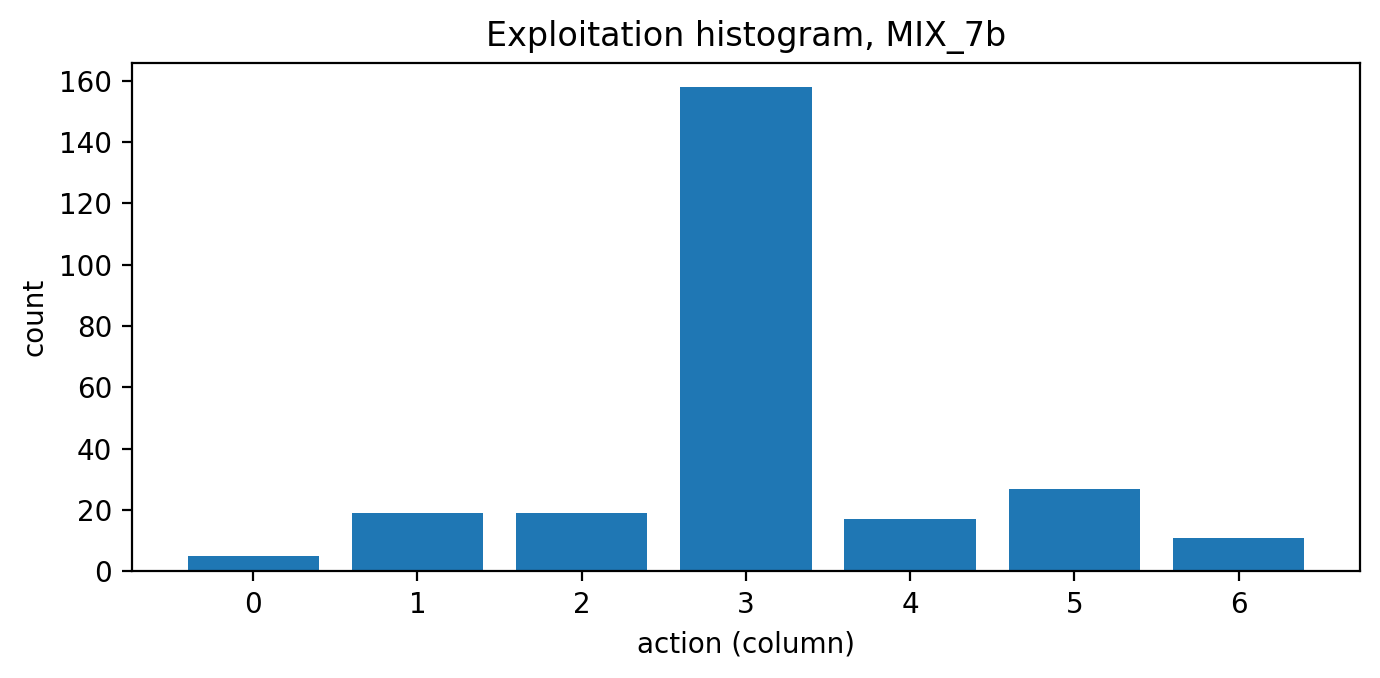

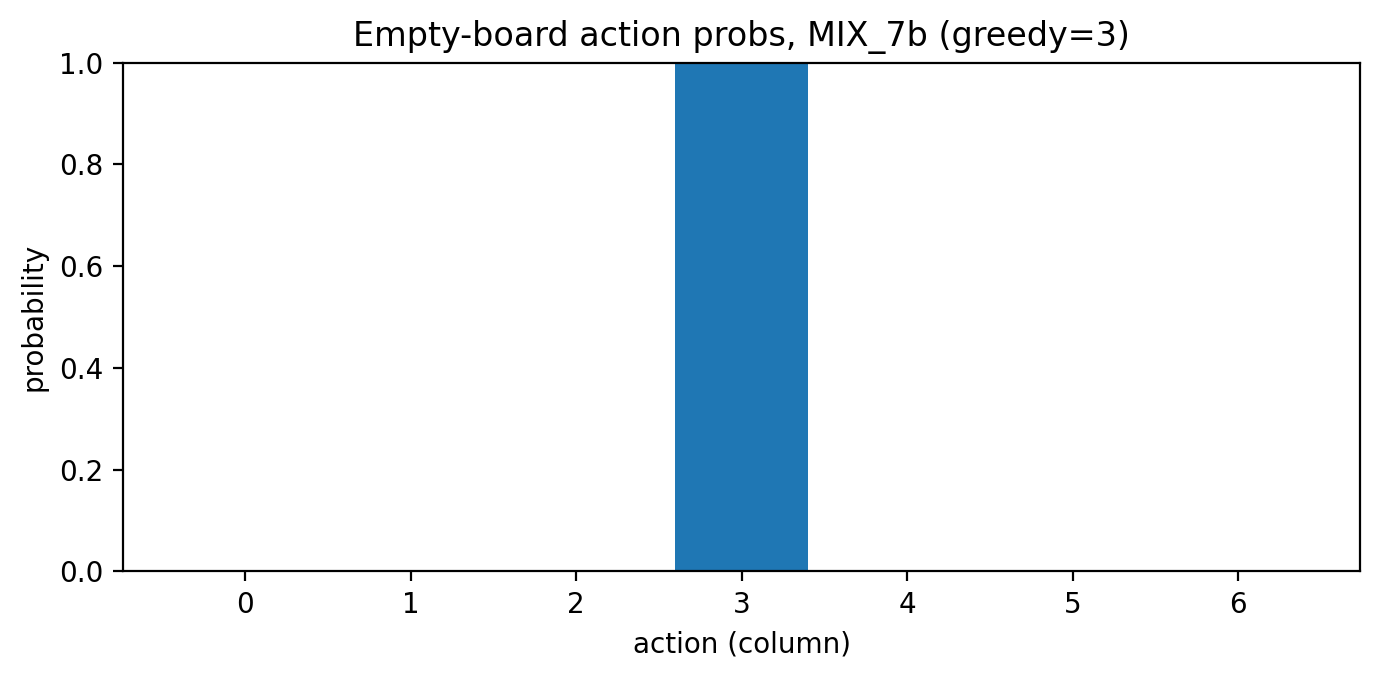

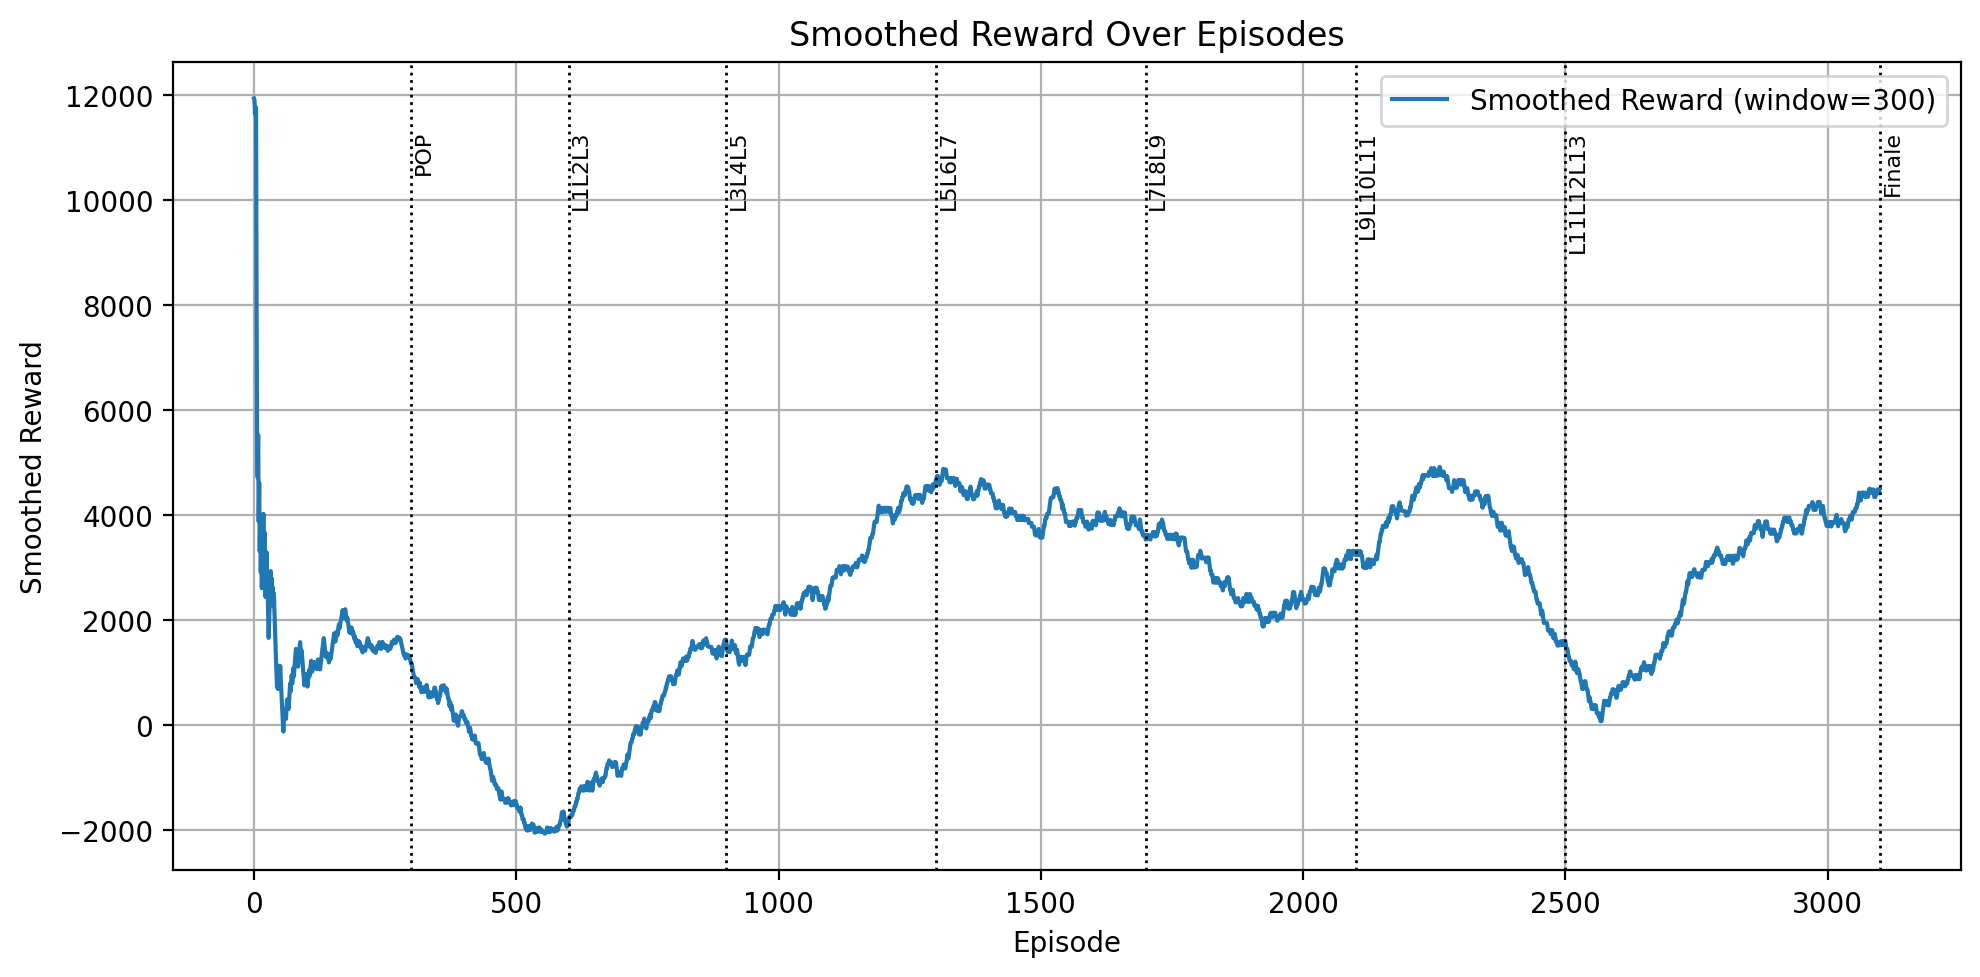

In [22]:
window = 300
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]

final_reward_fig, final_reward_ax = plt.subplots(figsize=(10, 5))
final_reward_ax.plot(smoothed, label=f"Smoothed Reward (window={window})")

# --- Add phase transitions ---
y_text = np.nanmax(smoothed) if len(smoothed) else 0.0
for name, meta in TRAINING_PHASES.items():
    ep = meta.get("length", None)
    if ep is not None and ep <= len(reward_history):
        final_reward_ax.axvline(x=ep, color='black', linestyle='dotted', linewidth=1)
        final_reward_ax.text(ep + 5, y_text * 0.95, name, rotation=90, va='top', ha='left', fontsize=8)

final_reward_ax.set_title("Smoothed Reward Over Episodes")
final_reward_ax.set_xlabel("Episode")
final_reward_ax.set_ylabel("Smoothed Reward")
final_reward_ax.legend()
final_reward_ax.grid(True)
final_reward_fig.tight_layout()
plt.show()


In [23]:
 fig = plot_live_training_ppo(
                episode=episode,
                reward_history=reward_history,
                win_history=win_history,
                phase_name=current_phase_name,
                win_count=win_count,
                loss_count=loss_count,
                draw_count=draw_count,
                metrics_history=ppo_metrics_history,
                benchmark_history=benchmark_history,
                title=TRAINING_SESSION,
                phases=TRAINING_PHASES,
                save=True,
                save_path=PLOTS,
                opponent_timeline=opponent_timeline,
                overlay_last=100,
                h2h_history=h2h_history,
                ensemble_h2h_history = ensemble_h2h_history,
                openings=openings, 
                policy=policy,
            )
plt.close(fig)

[Saved] Plots/PPO/PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-12-24__complete_training_plot.png


### Post training

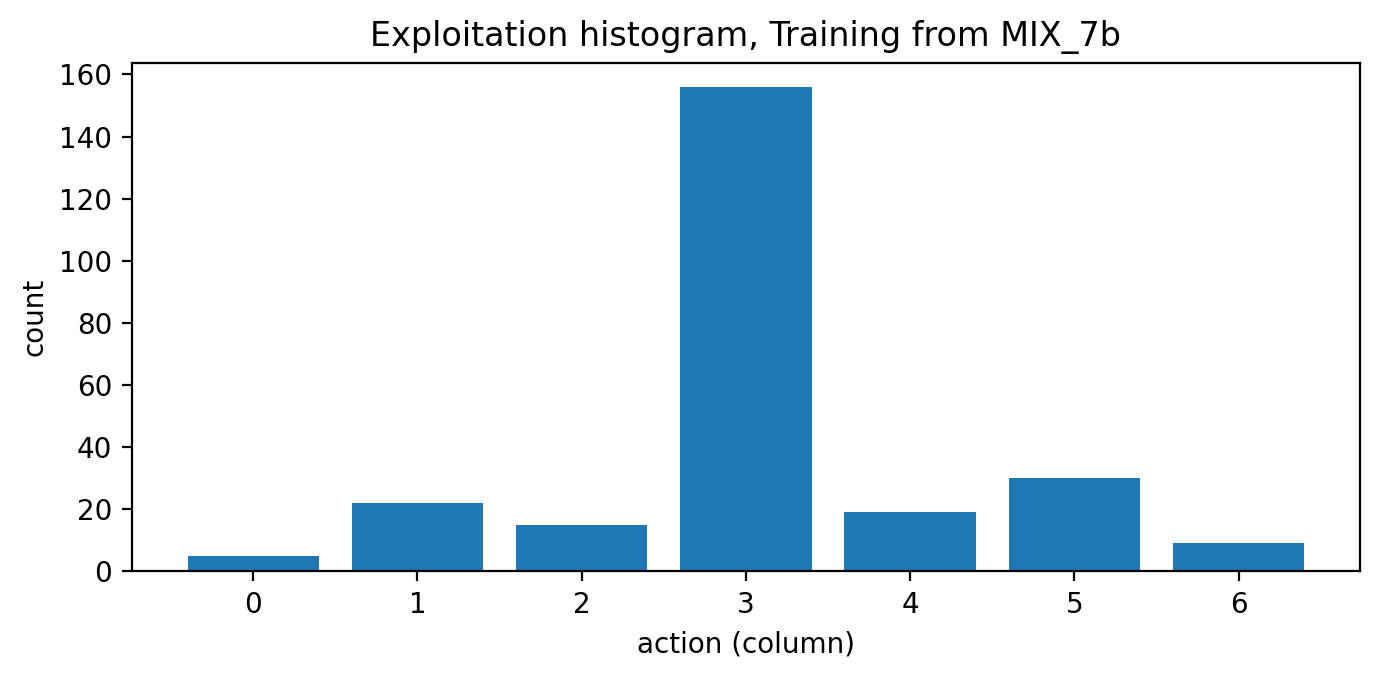

In [24]:
cnt = exploitation_histogram(policy.net, device=DEVICE, n_states=256, rng_seed=666, deterministic=True, temperature=float(temperature_ref["T"]))
EH = plot_exploitation_histogram(cnt, f"Training from {model_name}")
plt.show()

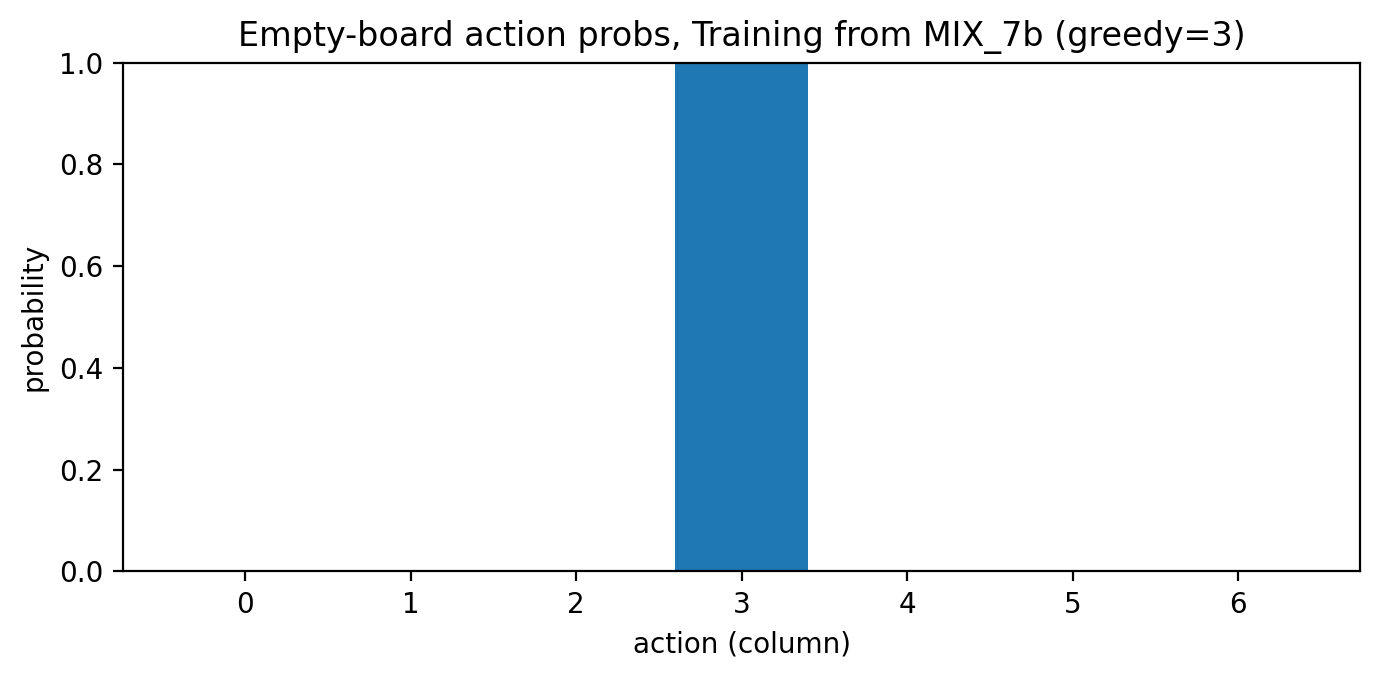

In [25]:
EBA = plot_empty_board_action_distribution(policy.net,device=DEVICE,model_name=f"Training from {model_name}",temperature=float(temperature_ref["T"]))
plt.show()

## Save model

In [26]:
from dataclasses import asdict

timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 ppo_model_{timestamp} episodes-{number_episodes}.pt"
default_model_path = "Connect4 PPQ model.pt"

save_cnet192(
                    model=policy.net,
                    path=model_path,
                    tag=model_name,
                    session=TRAINING_SESSION,
                    episode=episode,
                    seed=int(H2H_SEED),
                    score=float(score),
                    t=time.time() - start_time,
                )

# convenient overwrite / "latest" alias

save_cnet192(
                    model=policy.net,
                    path=default_model_path,
                    tag=model_name,
                    session=TRAINING_SESSION,
                    episode=episode,
                    seed=int(H2H_SEED),
                    score=float(score),
                    t=time.time() - start_time,
                )

print(f"Model saved to {model_path}\nAlso wrote: {default_model_path}")


Model saved to Models/PPO/PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-12-24_Connect4 ppo_model_20251229-130659 episodes-3100.pt
Also wrote: Connect4 PPQ model.pt


# Evaluation

In [27]:
suite_df, row_df = evaluate_and_log_to_excel(
    policy=policy,
    opponents_cfg=EVALUATION_OPPONENTS,
    excel_path="EVAL_PPO_results.xlsx",
    run_tag=TRAINING_SESSION,
    device=DEVICE,
    lookahead=Lookahead,
    seed=SEED,
    episodes=episode,
    progress=True,
)

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

In [28]:
display(suite_df)

opponent  games  wins  losses  draws  win_rate  loss_rate  draw_rate  \
0         Random    200   191       9      0     0.955      0.045        0.0   
1       Leftmost    100   100       0      0     1.000      0.000        0.0   
2         Center    200   200       0      0     1.000      0.000        0.0   
3    Lookahead-1    100    50      50      0     0.500      0.500        0.0   
4    Lookahead-2    100   100       0      0     1.000      0.000        0.0   
5    Lookahead-3    100     0     100      0     0.000      1.000        0.0   
6    Lookahead-4    100   100       0      0     1.000      0.000        0.0   
7    Lookahead-5     50    25      25      0     0.500      0.500        0.0   
8    Lookahead-6     24    24       0      0     1.000      0.000        0.0   
9    Lookahead-7     10    10       0      0     1.000      0.000        0.0   
10   Lookahead-9      6     6       0      0     1.000      0.000        0.0   
11  Lookahead-11      4     4       0      0     1.000      0.000        0.0   
12  Lookahead-13      4     2       2      0     0.500      0.500        0.0   

    score  avg_plies  
0   0.955     14.425  
1   1.000     10.500  
2   1.000     19.500  
3   0.500     21.000  
4   1.000     16.500  
5   0.000     27.500  
6   1.000     16.500  
7   0.500     15.000  
8   1.000     16.500  
9   1.000     33.500  
10  1.000     30.500  
11  1.000     35.500  
12  0.500     33.000

In [29]:
display(row_df)

TIME [h]  EPISODES  \
TRAINING_SESSION                                                         
PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-1...   0.01953      3100   

                                                    Random  Leftmost  Center  \
TRAINING_SESSION                                                               
PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-1...   0.955       1.0     1.0   

                                                    Lookahead-1  Lookahead-2  \
TRAINING_SESSION                                                               
PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-1...          0.5          1.0   

                                                    Lookahead-3  Lookahead-4  \
TRAINING_SESSION                                                               
PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-1...          0.0          1.0   

                                                    Lookahead-5  Lookahead-6  \
TRAINING_SESSION                                                               
PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-1...          0.5          1.0   

                                                    Lookahead-7  Lookahead-9  \
TRAINING_SESSION                                                               
PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-1...          1.0          1.0   

                                                    Lookahead-11  Lookahead-13  
TRAINING_SESSION                                                                
PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-1...           1.0           0.5

📊 Plot saved to Plots/PPO/PPO-PPQ-3100-L13-Finale-MIX_7b - at-2025-12-29 11-12-24-evaluation_plot.png


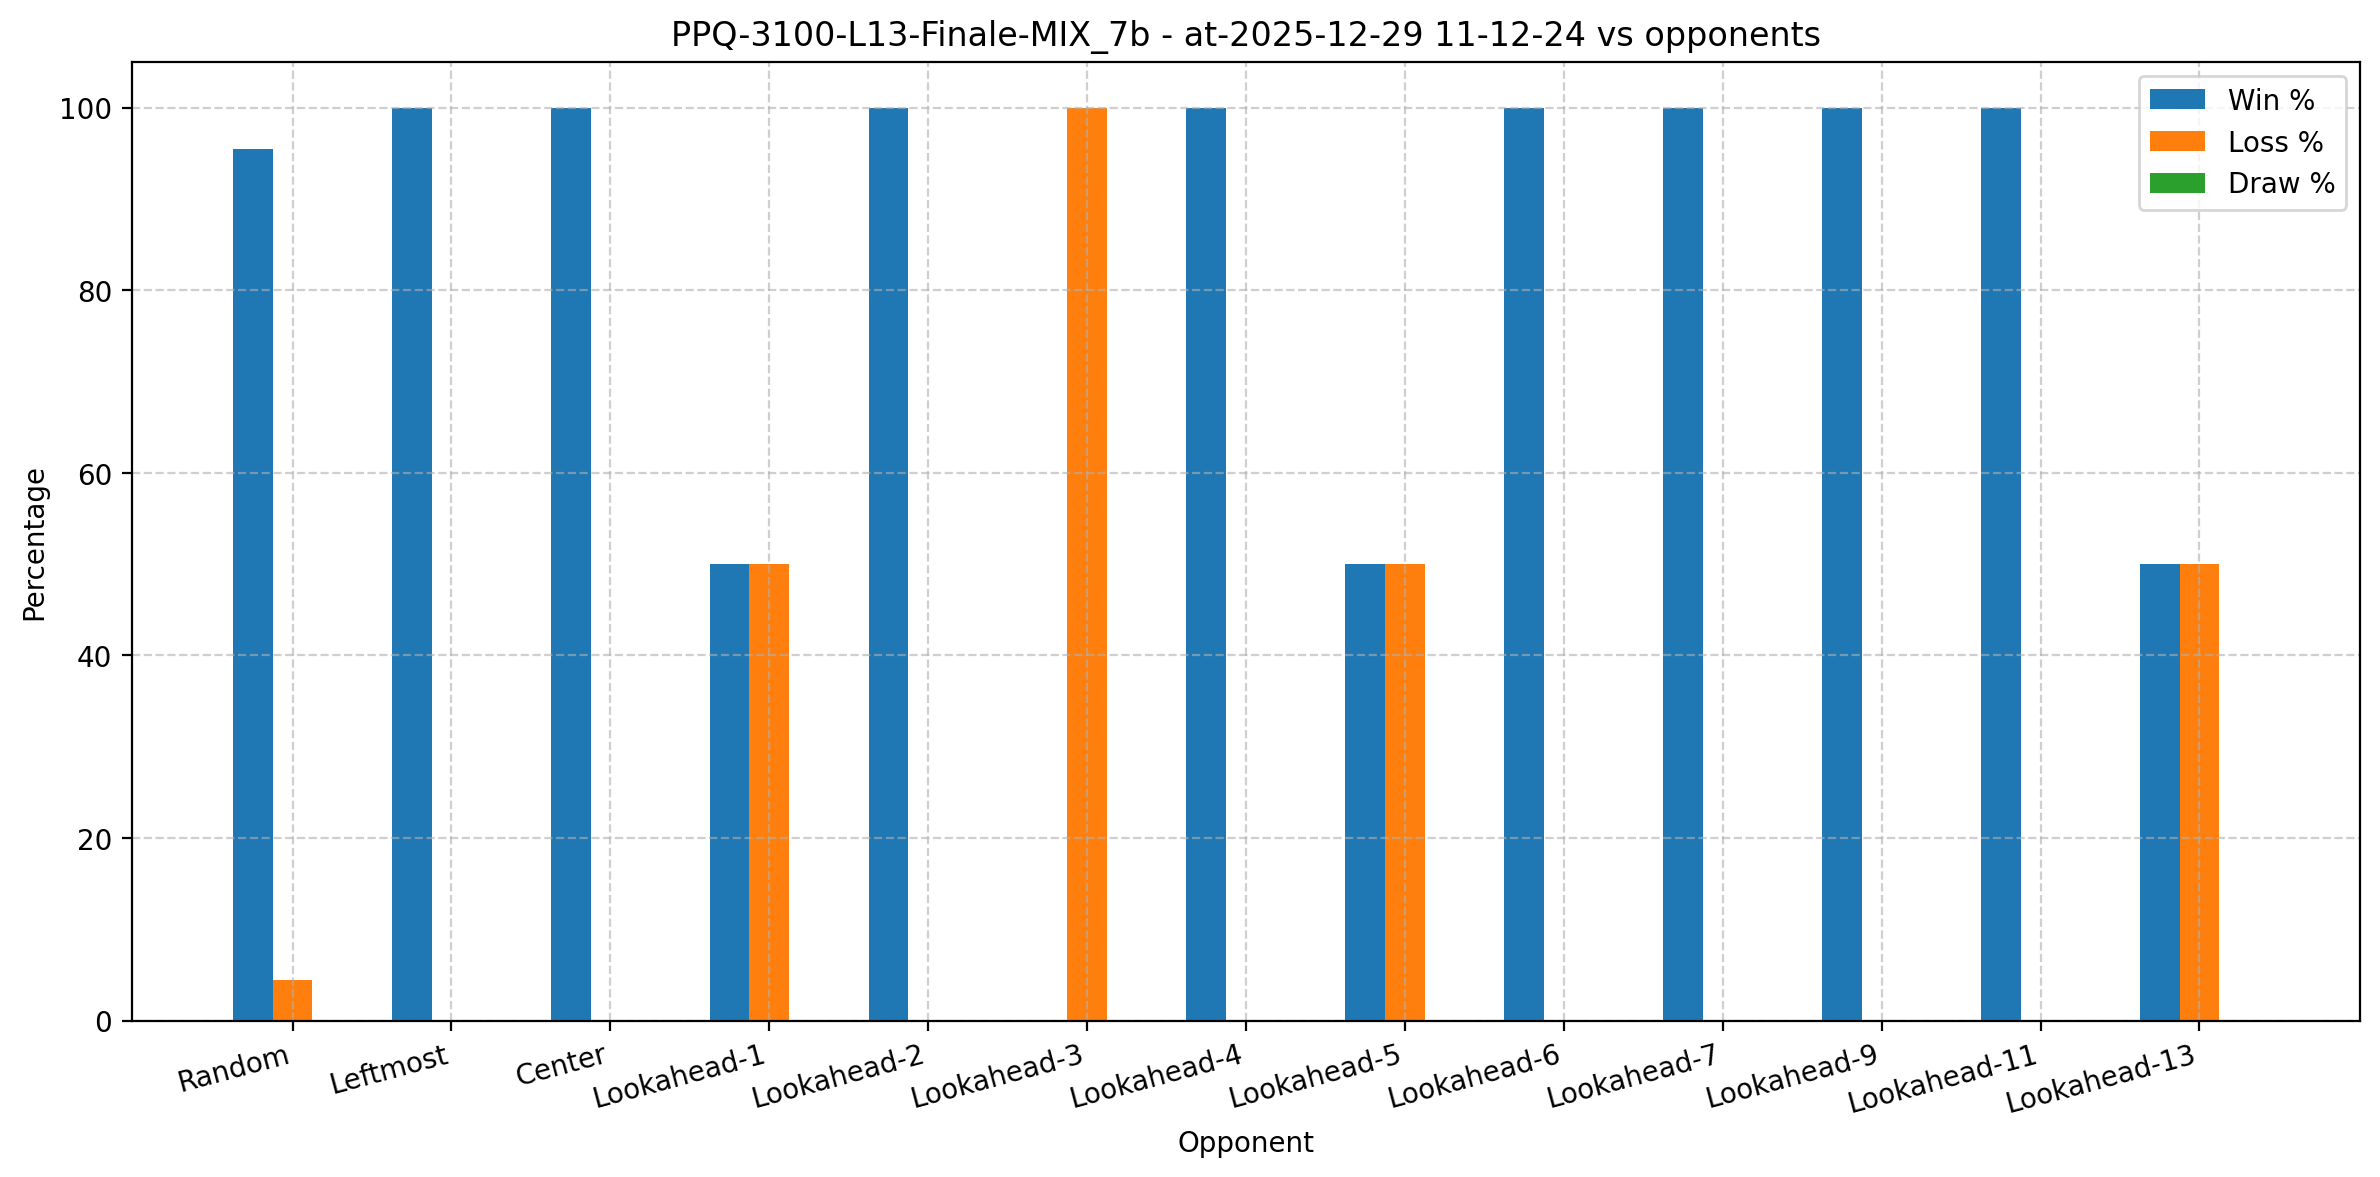

In [30]:
fig = plot_eval_bar_summary_from_suite_df(
    suite_df,
    model_name=TRAINING_SESSION,
    save_path=f"{PLOTS}PPO-{TRAINING_SESSION}-evaluation_plot.png",
)
import matplotlib.pyplot as plt
plt.show(fig)

### Boards

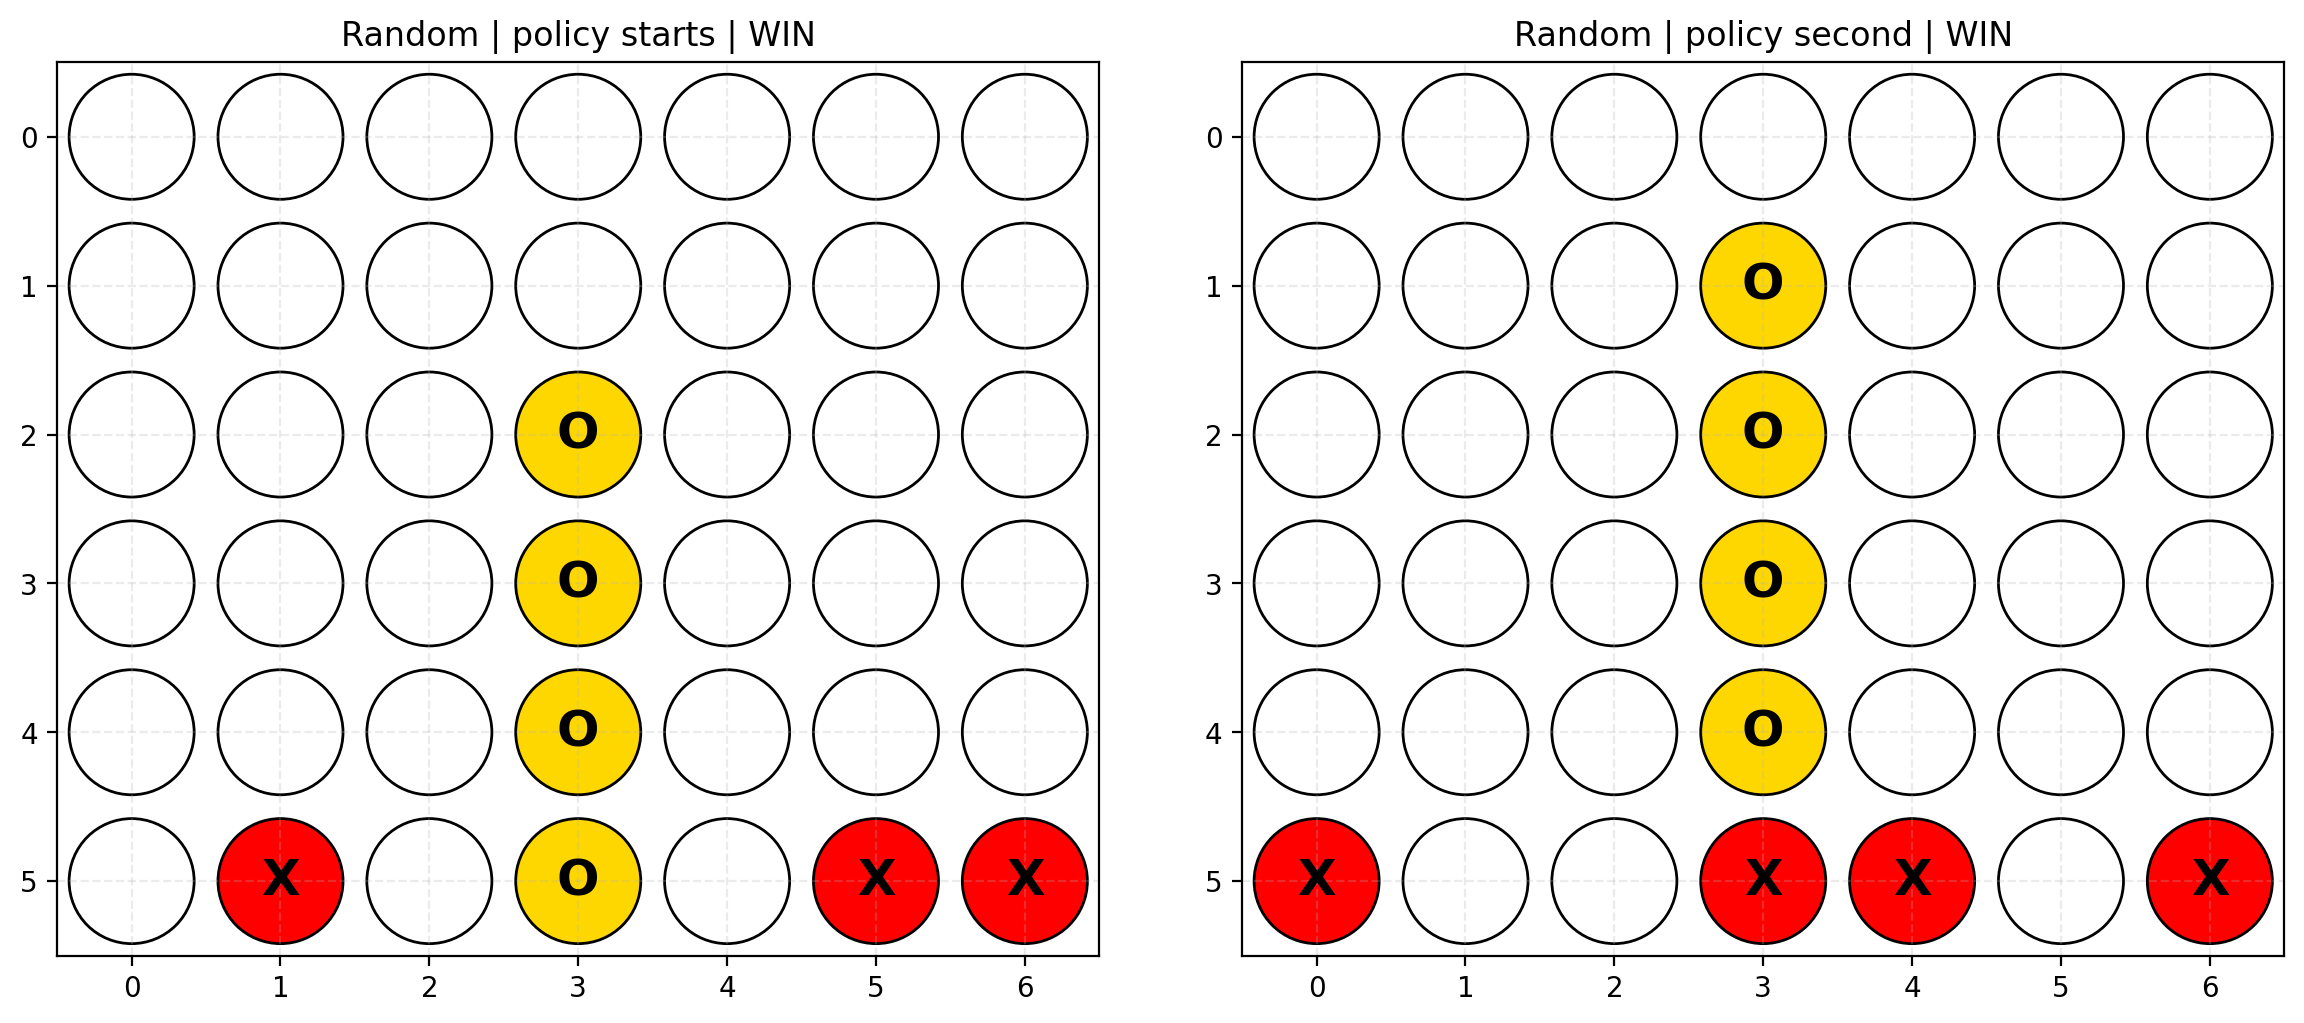

In [31]:
display_final_boards_PPO(policy, ["Random"])

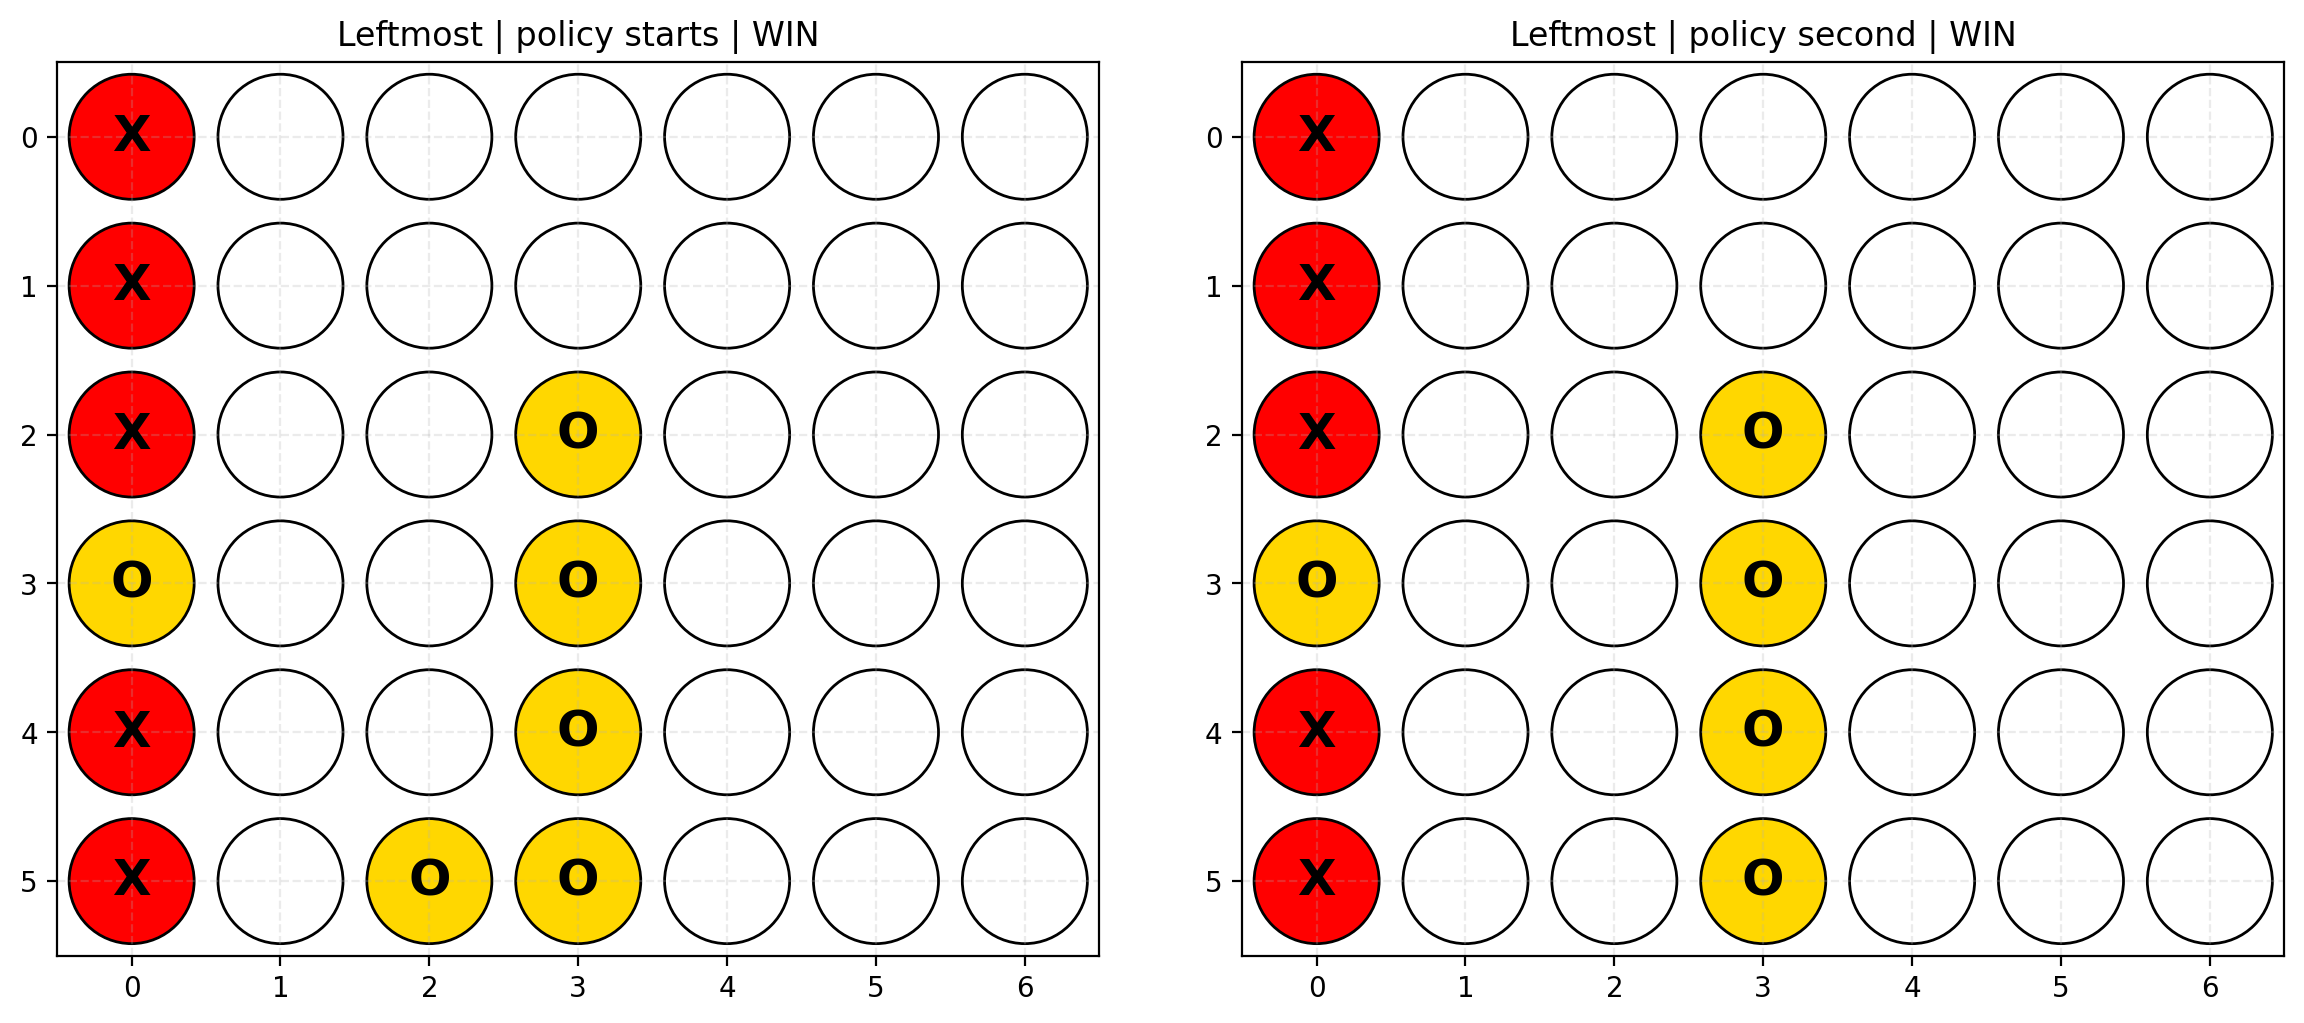

In [32]:
display_final_boards_PPO(policy, ["Leftmost"])

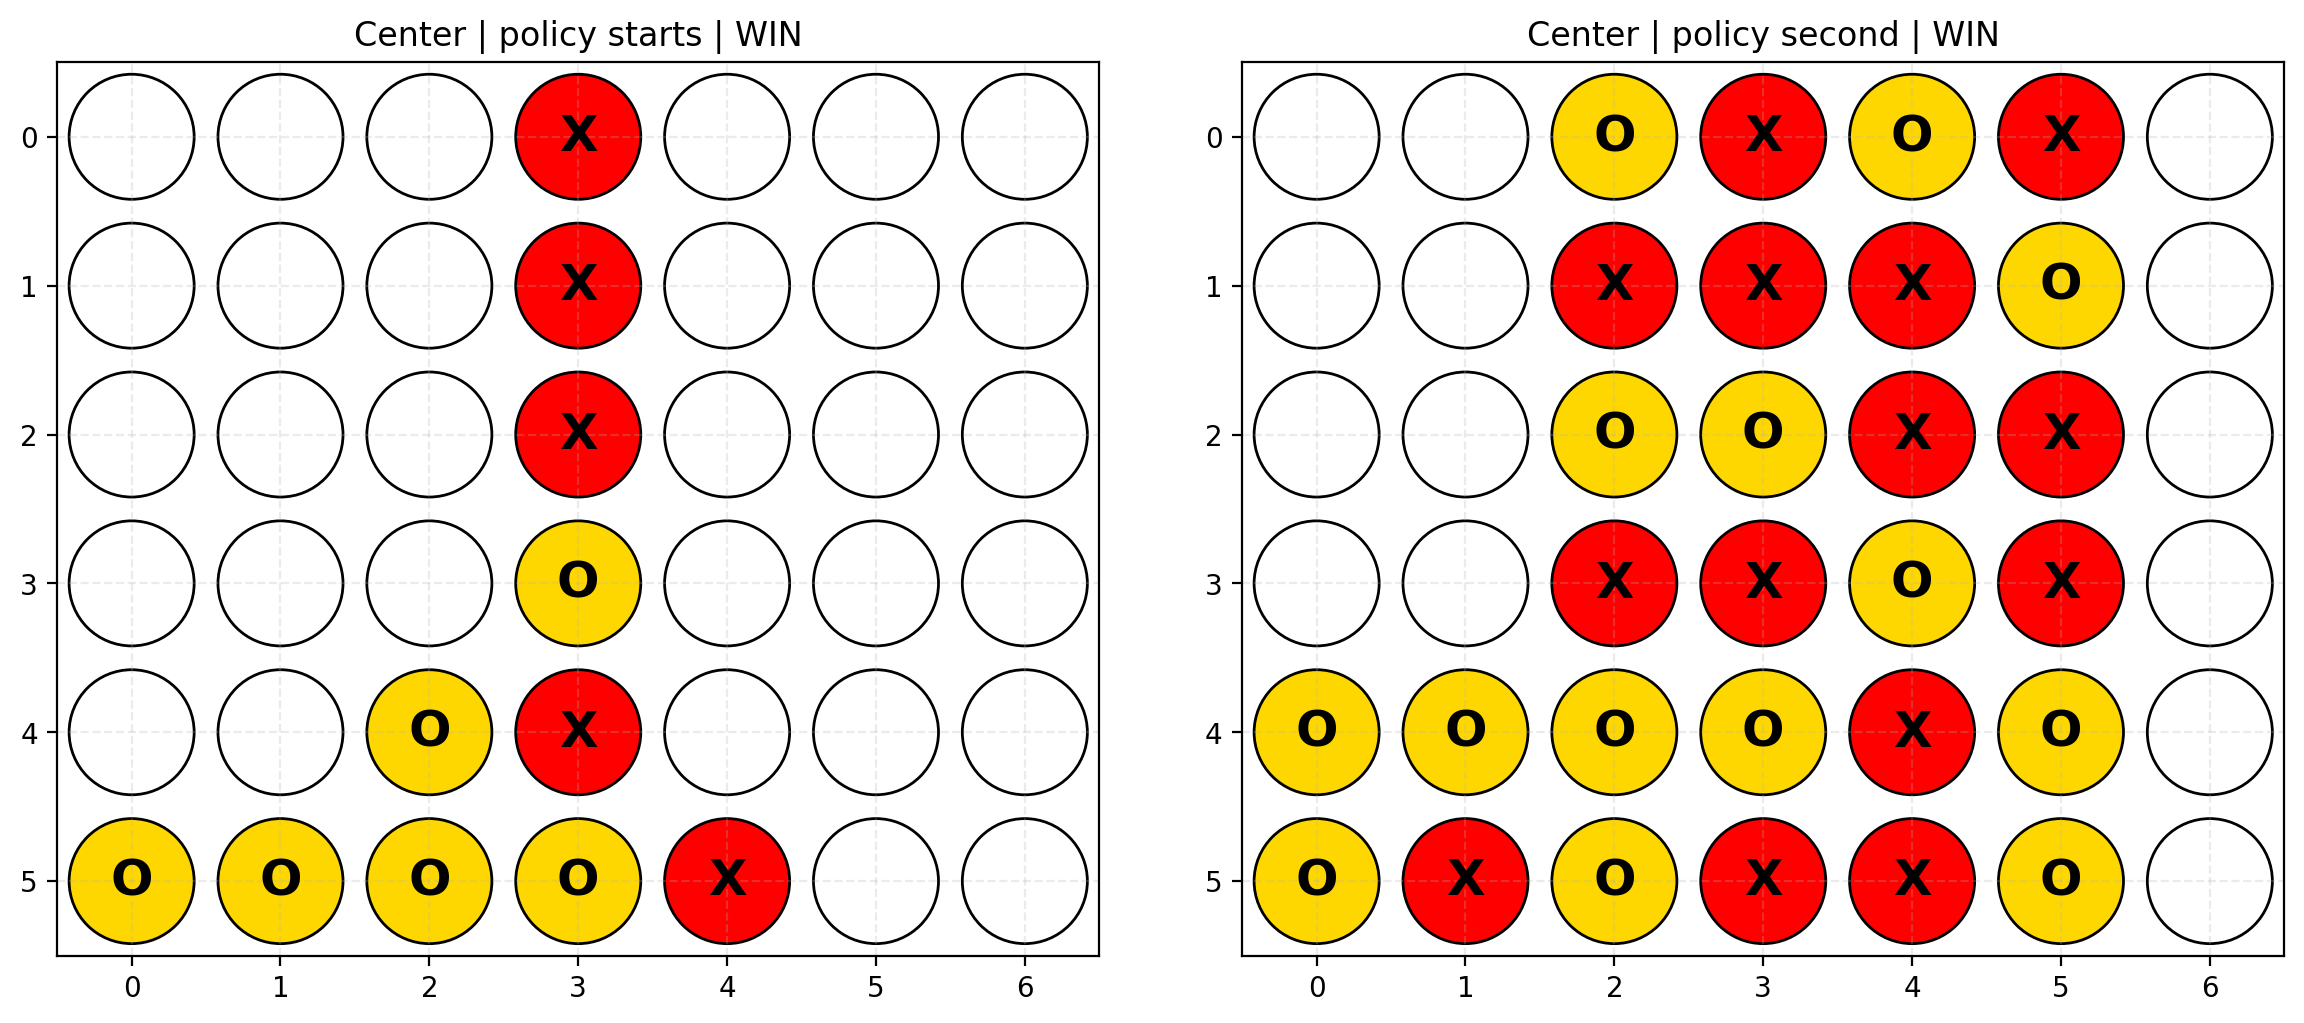

In [33]:
display_final_boards_PPO(policy, ["Center"])

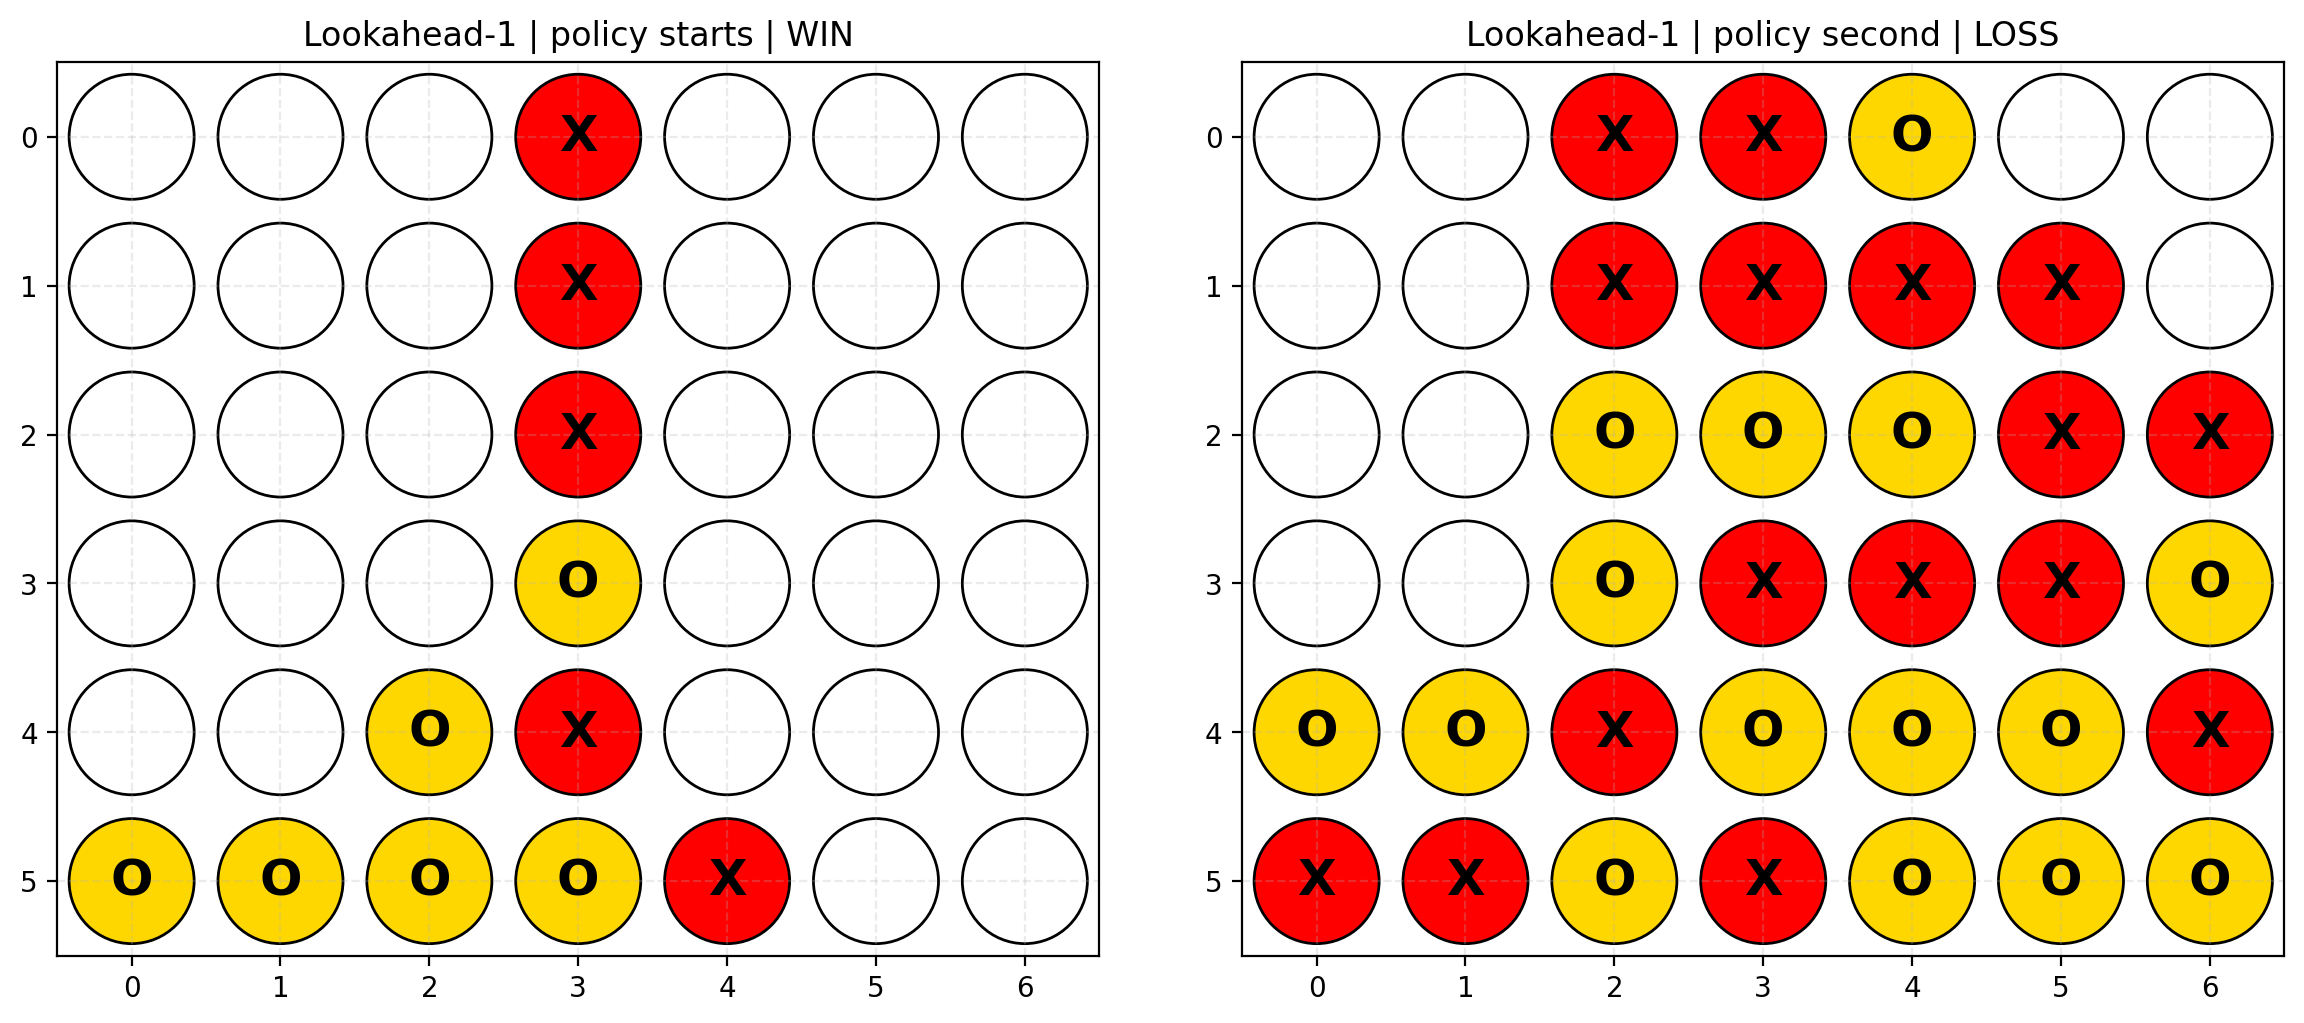

In [34]:
display_final_boards_PPO(policy, ["Lookahead-1"], lookahead = Lookahead)

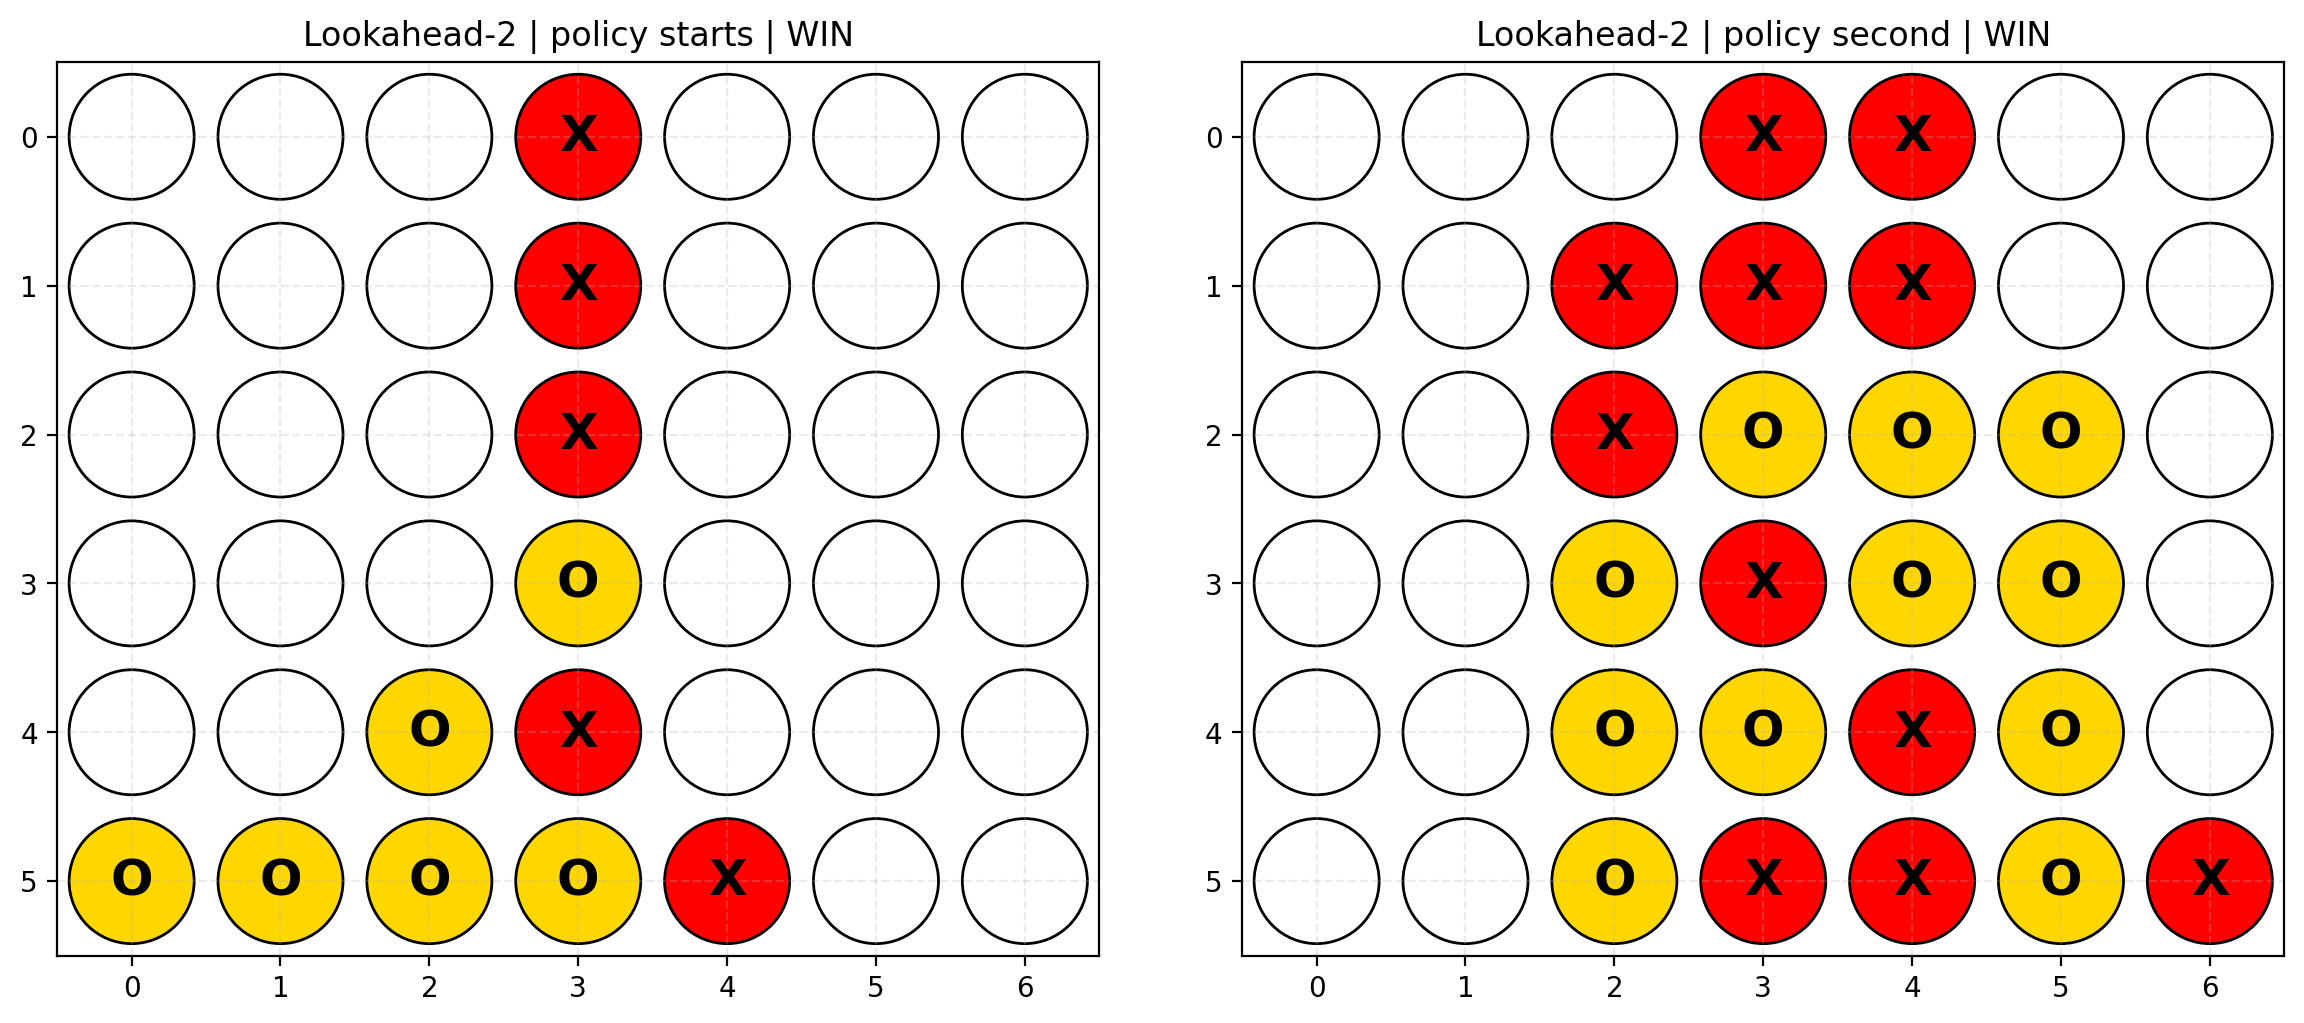

In [35]:
display_final_boards_PPO(policy, ["Lookahead-2"], lookahead = Lookahead)

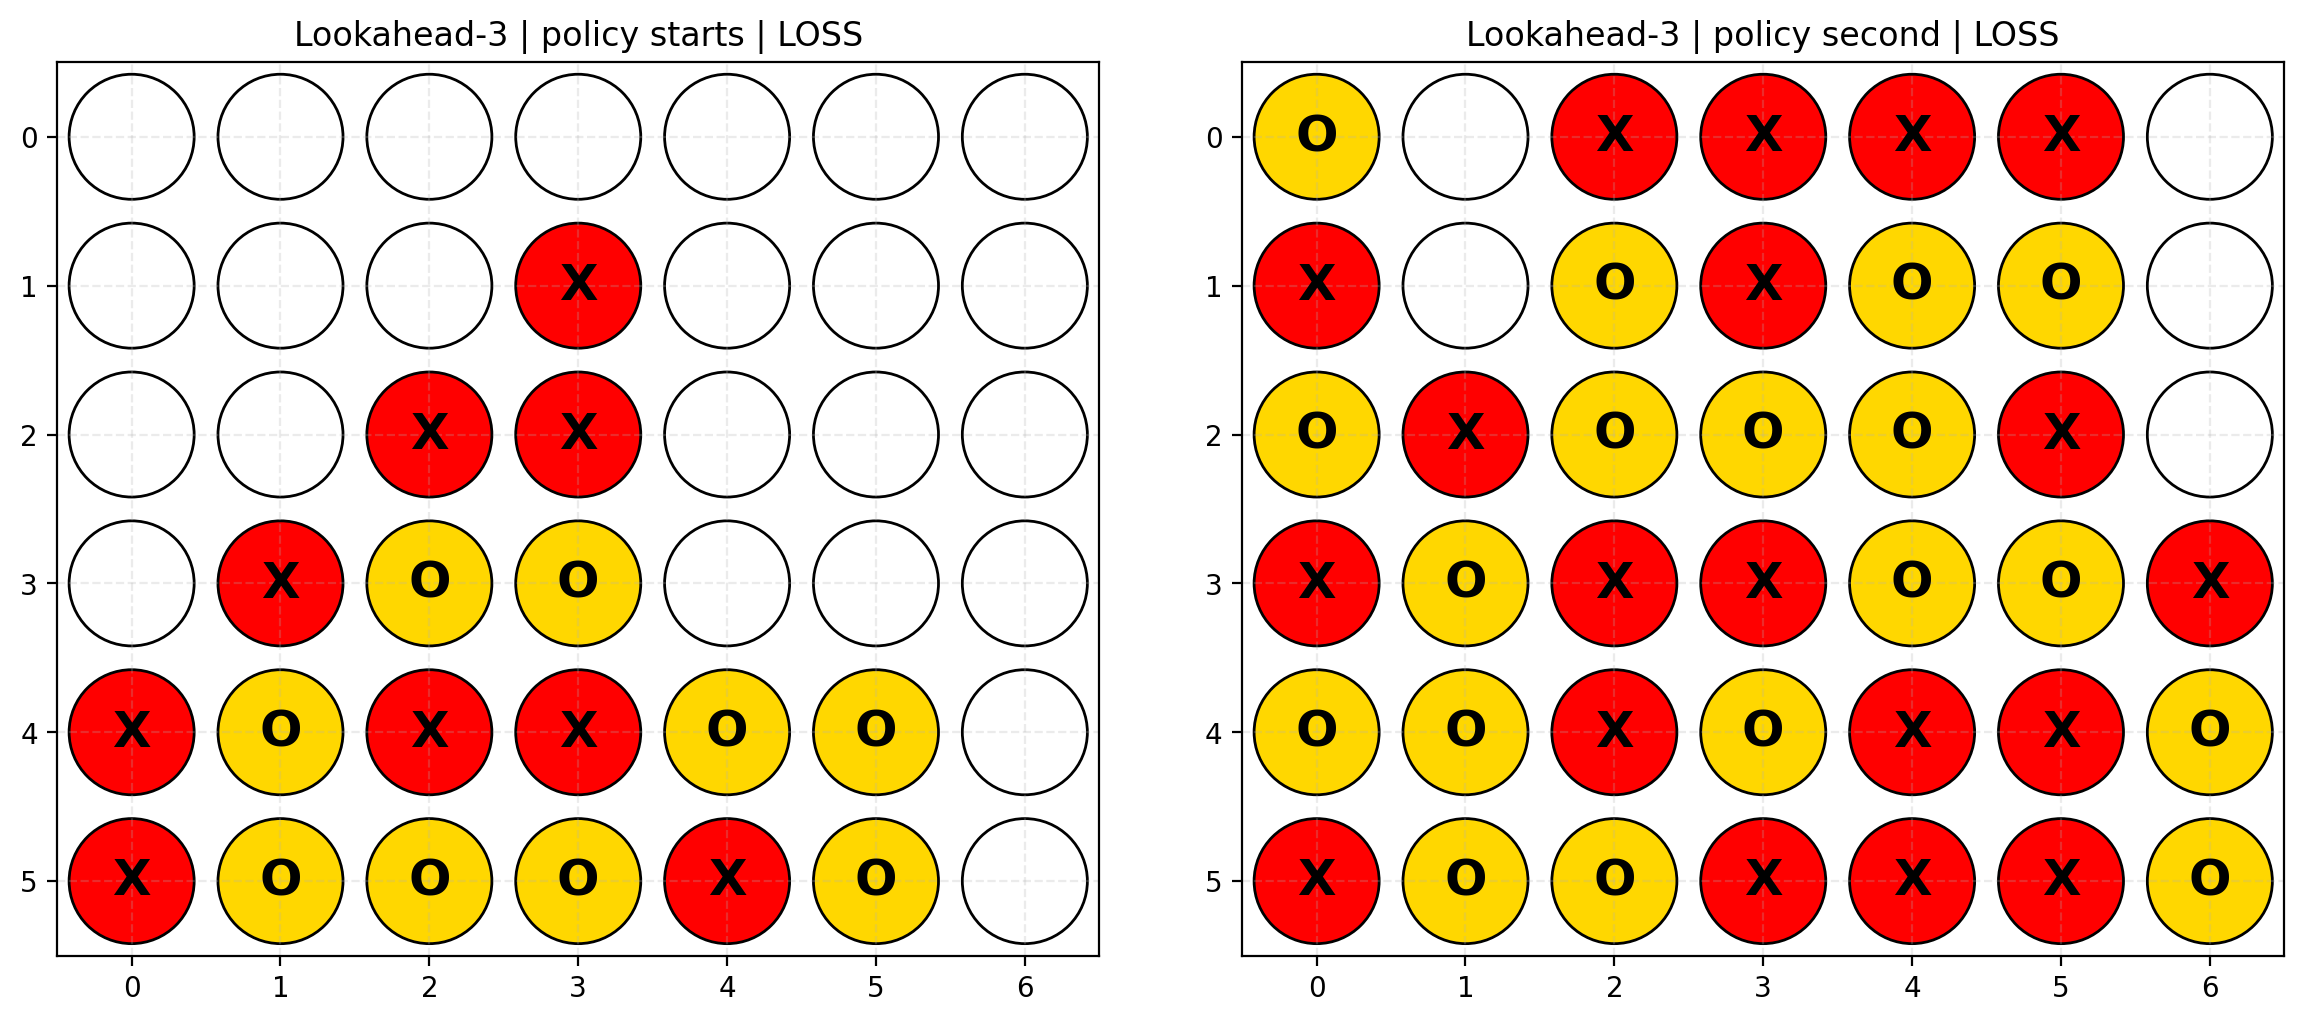

In [36]:
display_final_boards_PPO(policy, ["Lookahead-3"], lookahead = Lookahead)

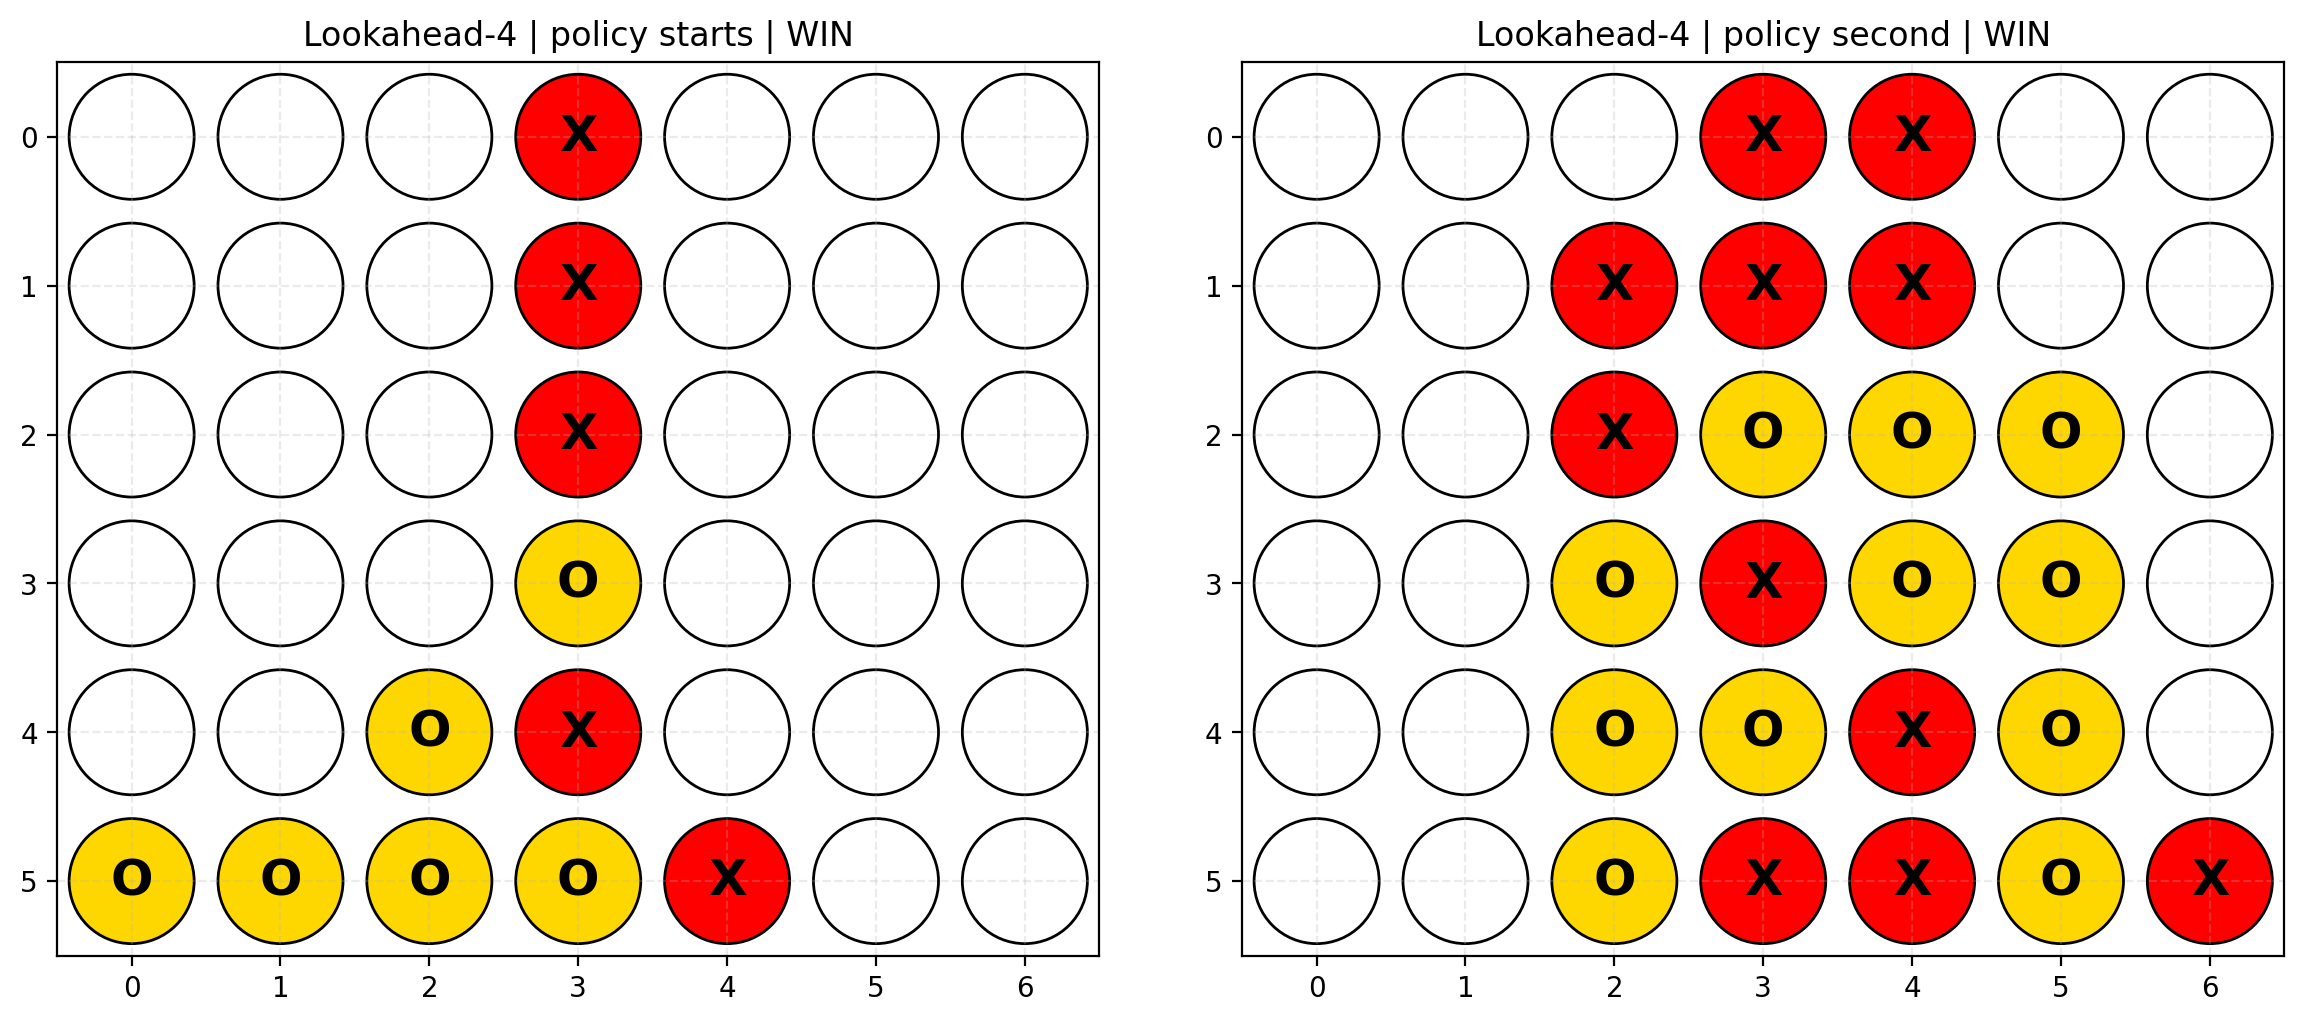

In [37]:
display_final_boards_PPO(policy, ["Lookahead-4"], lookahead = Lookahead)

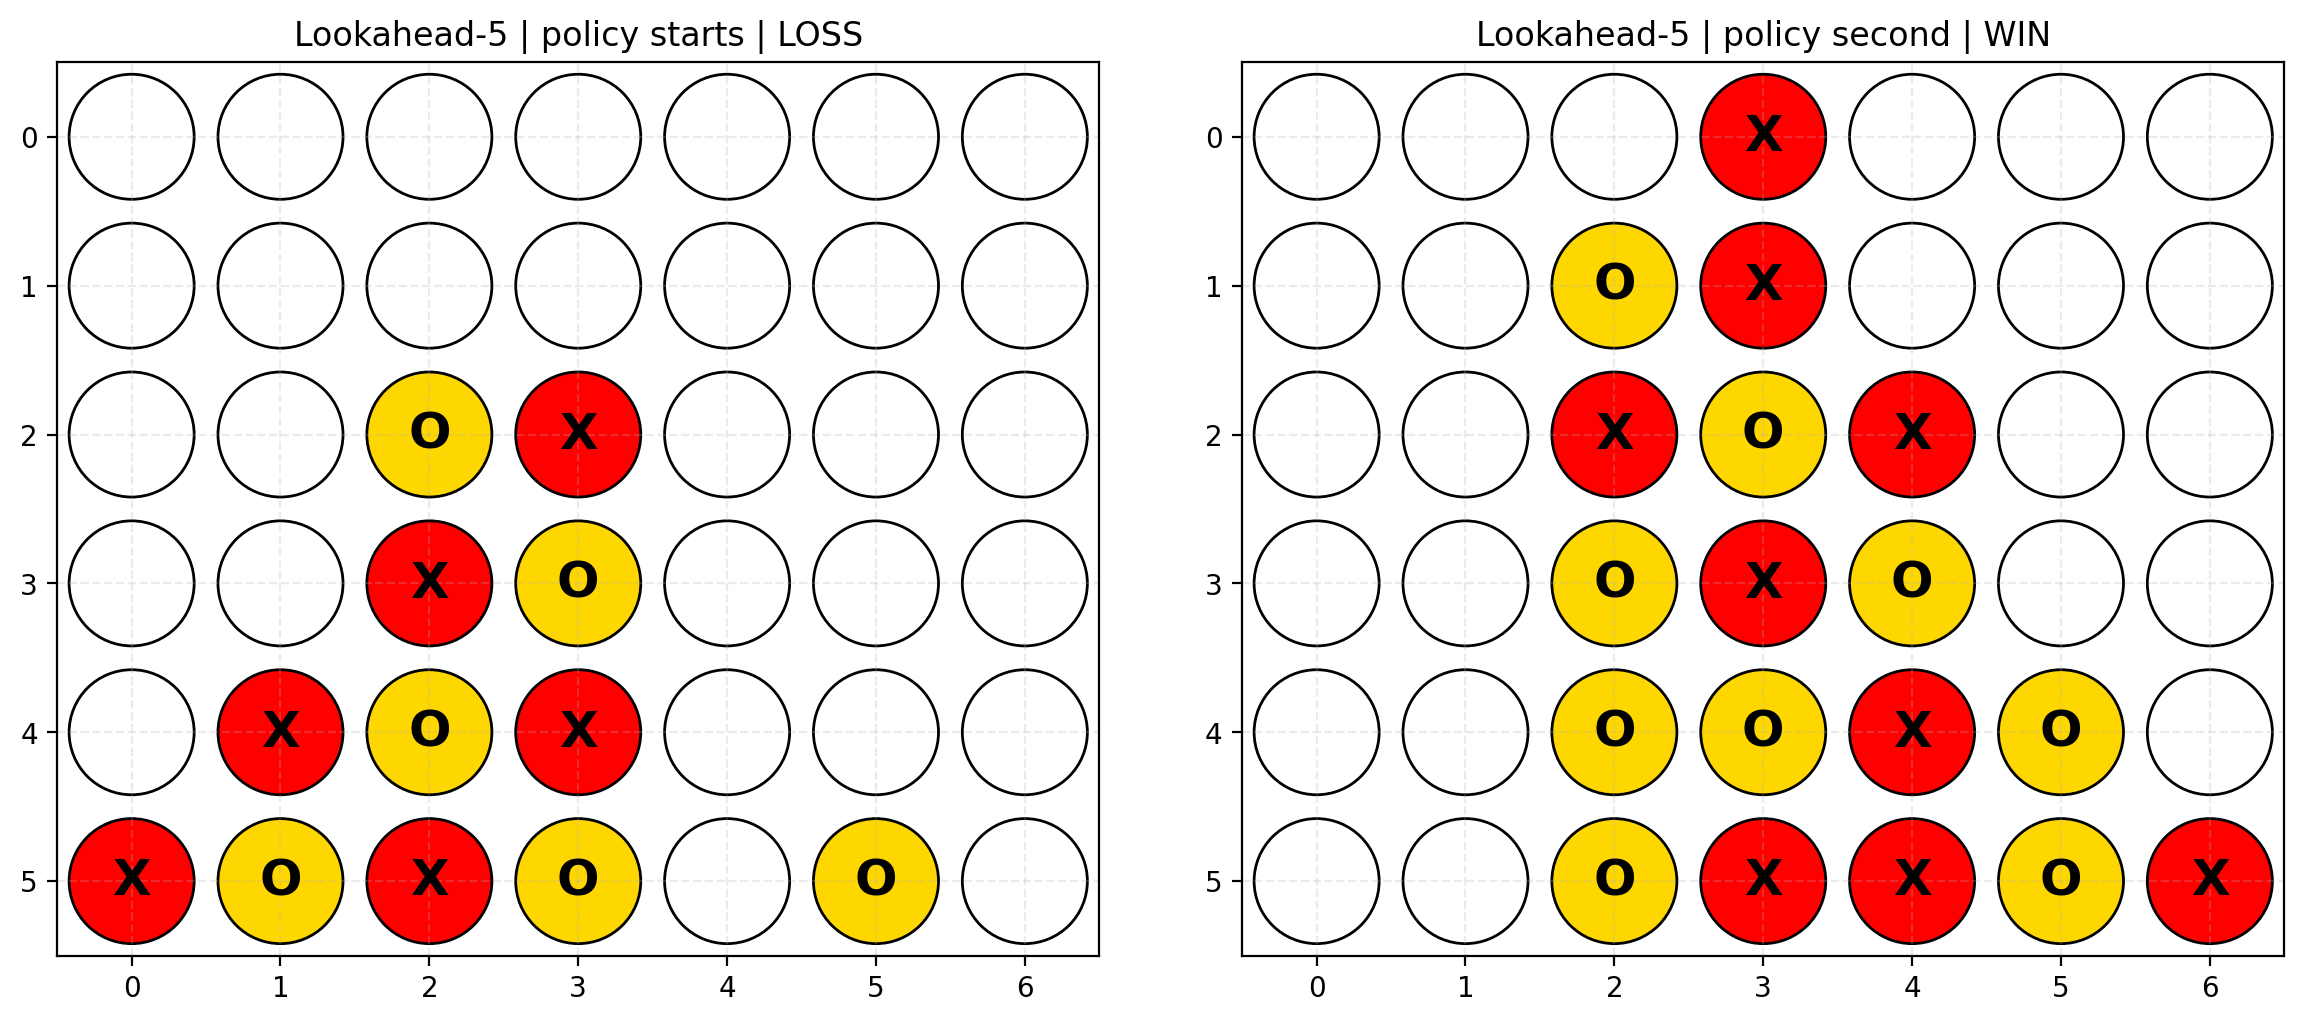

In [38]:
display_final_boards_PPO(policy, ["Lookahead-5"], lookahead = Lookahead)

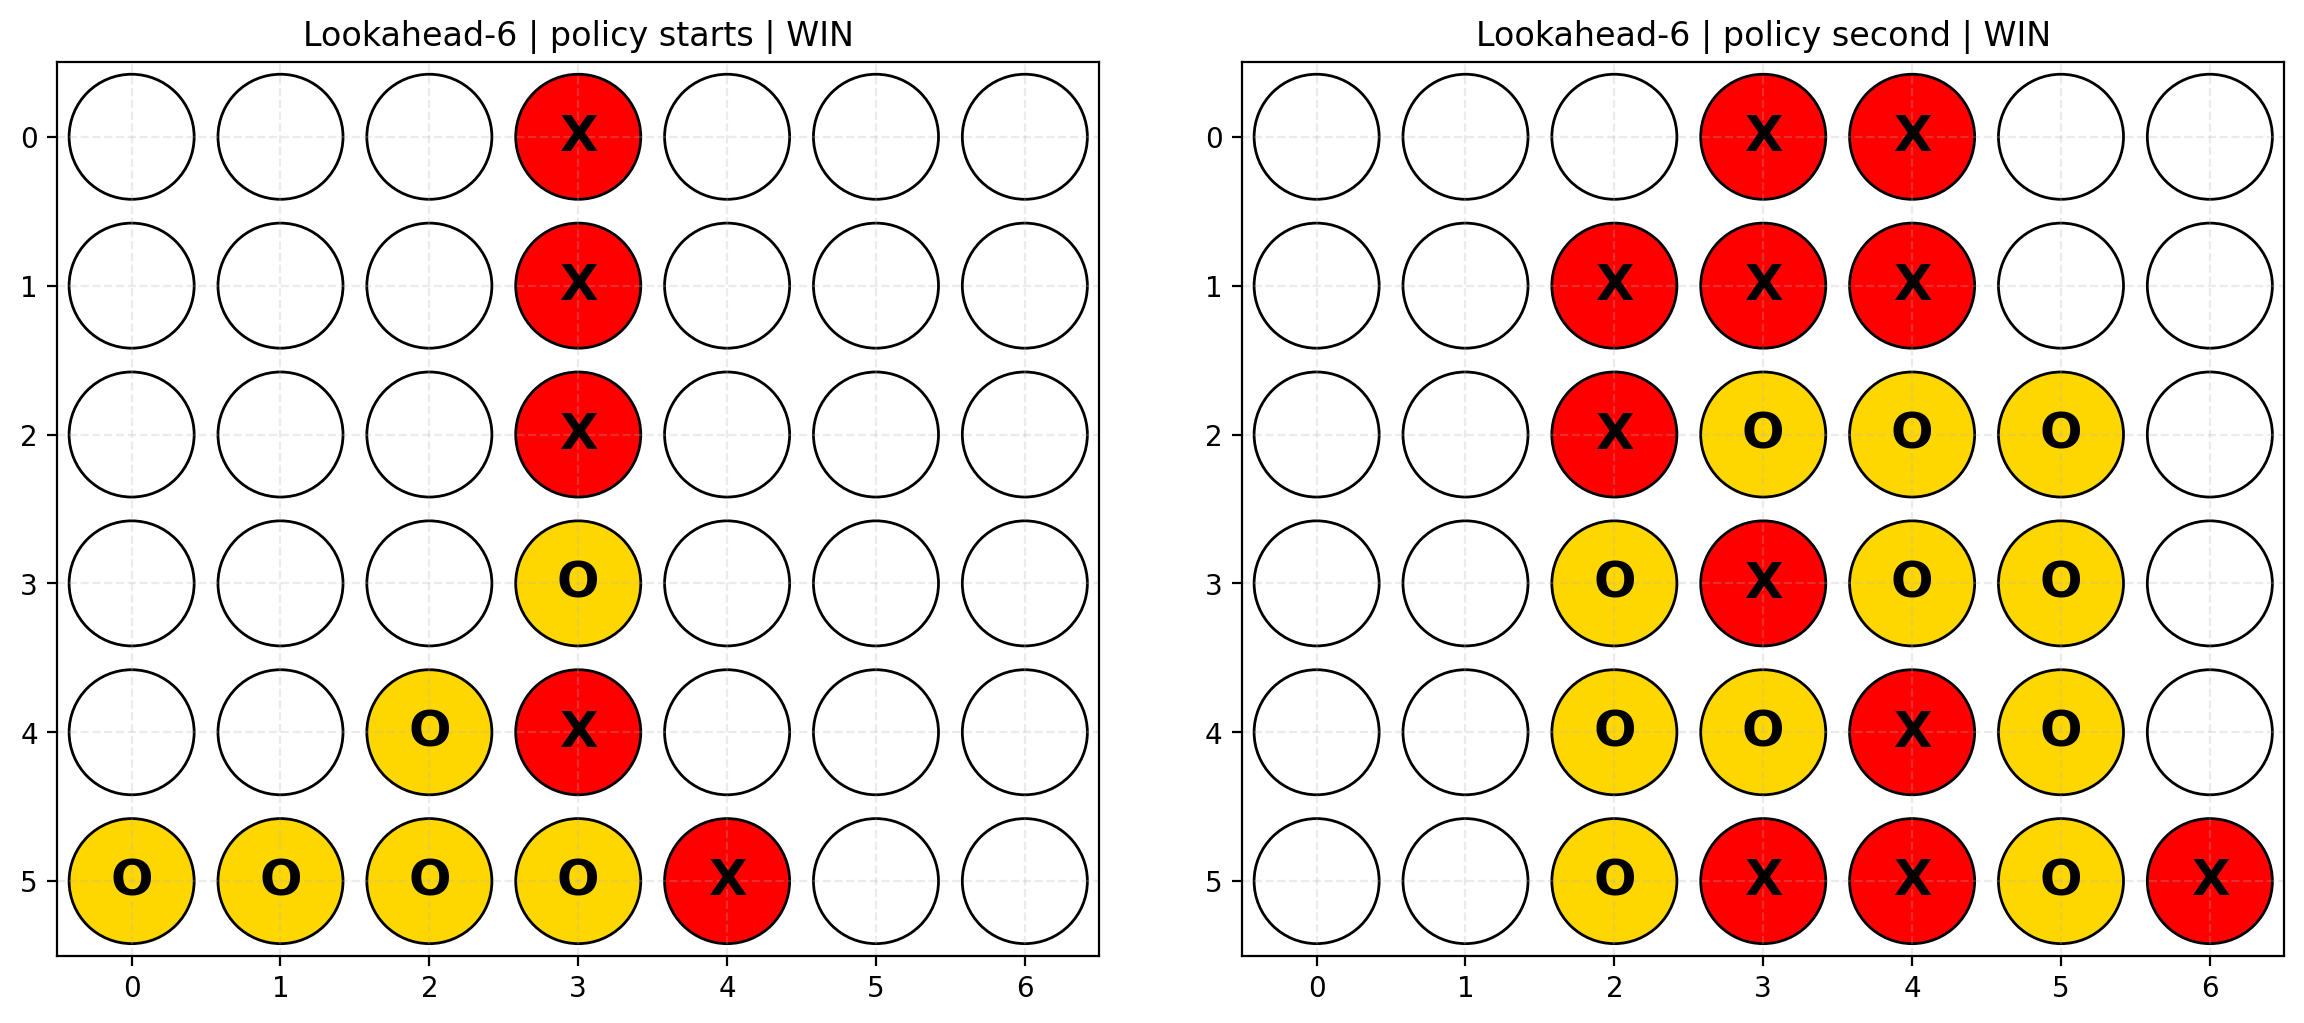

In [39]:
display_final_boards_PPO(policy, ["Lookahead-6"], lookahead = Lookahead)

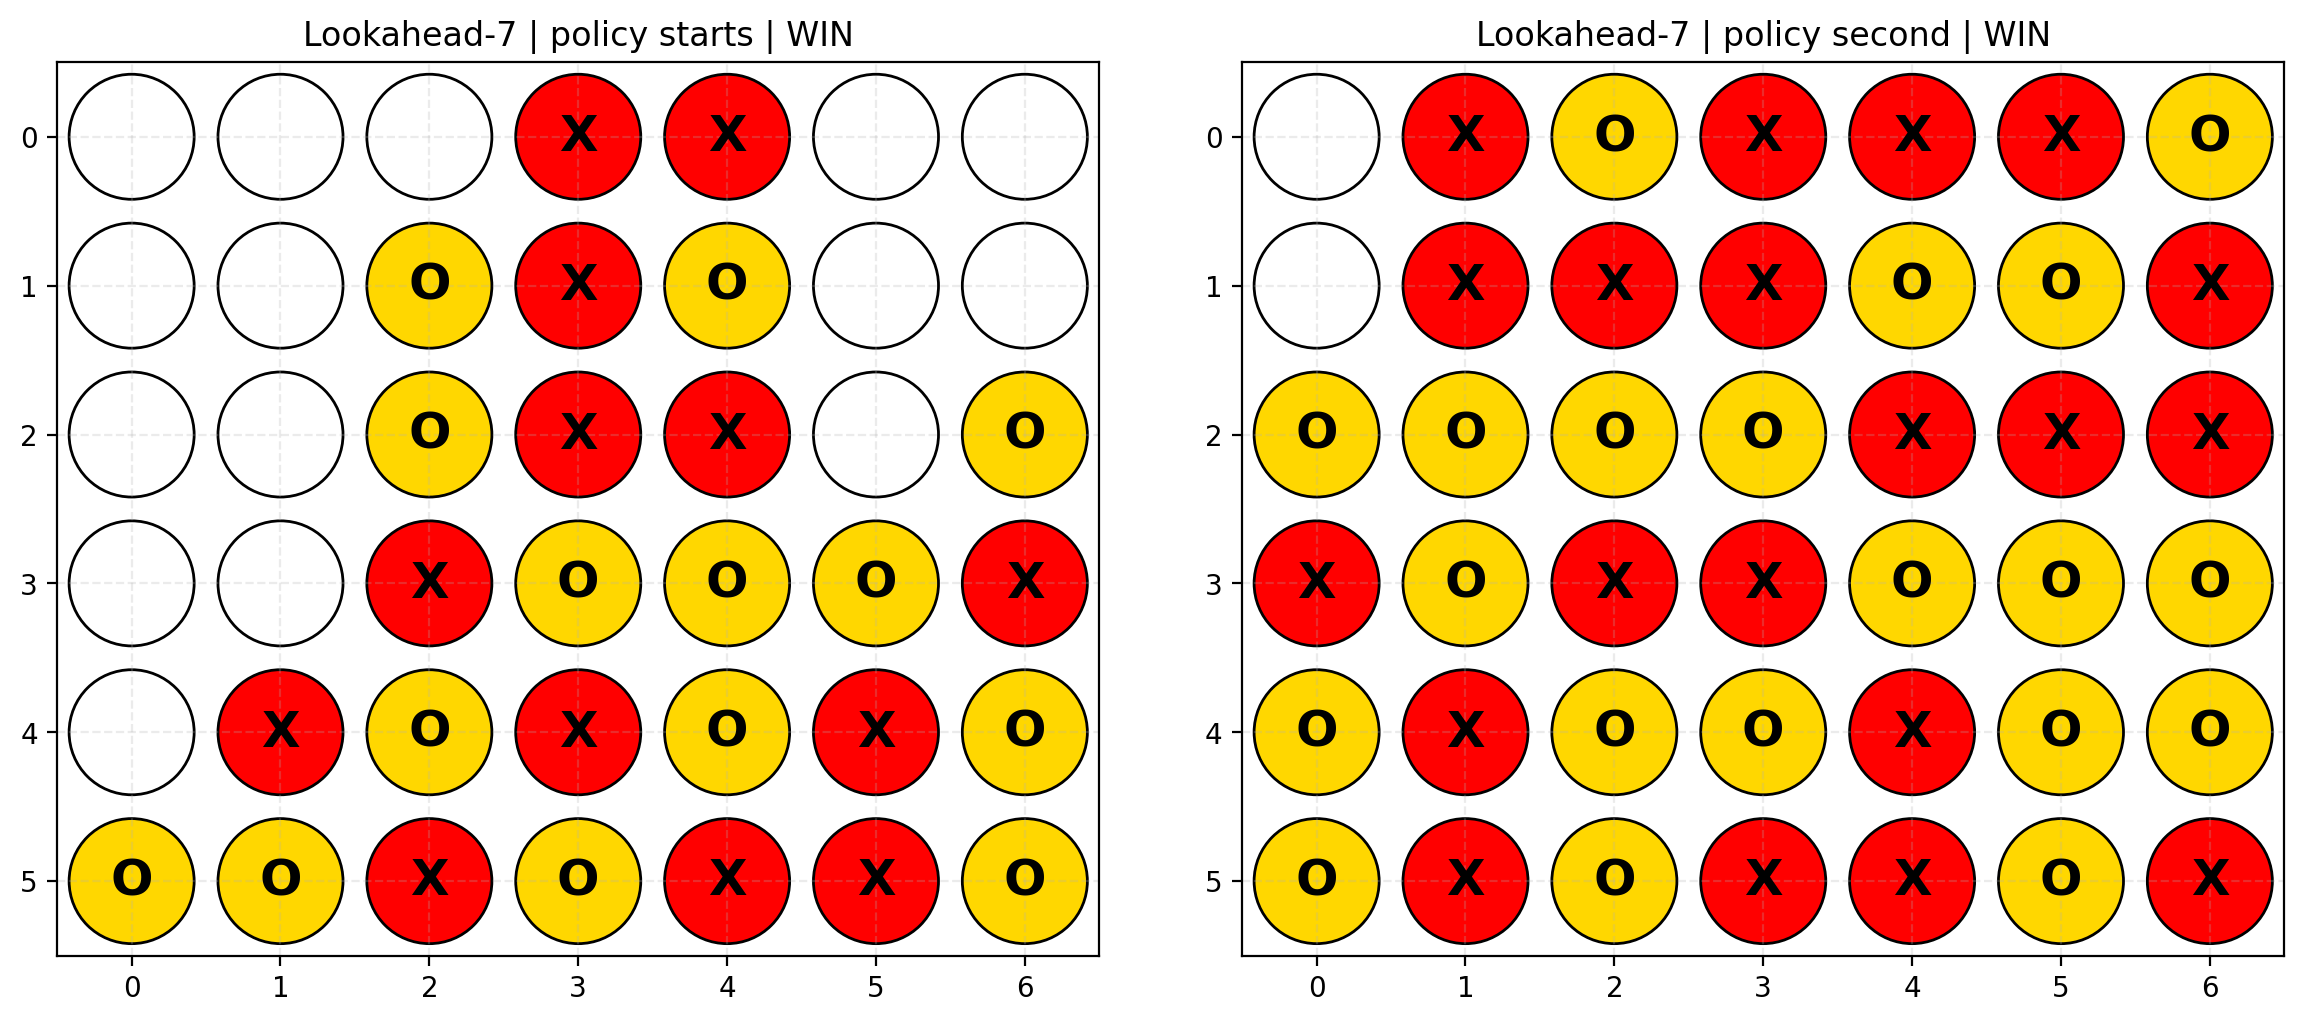

In [40]:
display_final_boards_PPO(policy, ["Lookahead-7"], lookahead = Lookahead)

# DONE

In [41]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 1.9 hours
